### Function

In [1]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
#     plt.figure()
#     generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
#     plt.show()

In [2]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [3]:
def show_values(axs, orient="v", space=.01, fmt='{:.4f}', fsize=18):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = fmt.format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=fsize) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = fmt.format(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=fsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Library

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyswarms as ps
import matplotlib.pyplot as plt
import xlsxwriter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

from ipynb.fs.full.DistanceWeightedKNN import DistanceWeightedKNN

In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

## Preprocessing

In [6]:
df= pd.read_csv("DATASET/GetahBening-Harvard.csv")
df.head(10)

Class  AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  AFFX-BioC-5_at  \
0  DLBCL            -104            -187             -26              59   
1  DLBCL            -152            -328             -52             267   
2  DLBCL            -158            -129              11              88   
3  DLBCL            -124            -121              -3             -37   
4  DLBCL             -93            -258             -36             109   
5  DLBCL             -34            -257            -104              71   
6  DLBCL            -251            -264             -99              31   
7  DLBCL            -204            -293             -32             148   
8  DLBCL            -144            -356            -194              84   
9  DLBCL             -94            -204             -28              53   

   AFFX-BioC-3_at  AFFX-BioDn-5_at  AFFX-BioDn-3_at  AFFX-CreX-5_at  \
0            -238             -258             -400            -146   
1            -300             -314              578            -185   
2            -239             -429             -891            -258   
3            -210             -309             -489             -69   
4            -109             -272             -469            -279   
5            -196             -250               10            -139   
6            -244             -110              128             -47   
7            -327             -215              -79            -196   
8            -269             -235             -268            -136   
9            -166             -284             -168            -158   

   AFFX-CreX-3_at  ...  U48730_at  U58516_at  U73738_at  X06956_at  X16699_at  \
0             -34  ...        132       1036       -161       1523        -72   
1             111  ...        147       4254        -75       6056        -68   
2              22  ...        169       1934       -129       2901         -9   
3             -35  ...         13       2469         93       2465       -119   
4             -90  ...         69        608        -39       1667        -87   
5              23  ...         47       1366        -21       4413        -69   
6              24  ...         27       3242       -694       2914       -449   
7             -57  ...         40       1499         61       2903        -20   
8               1  ...         89        604       -170       3374        -87   
9             -32  ...        151       5936       -128       5945        -80   

   X83863_at  Z17240_at  L49218_f_at  M71243_f_at  Z78285_f_at  
0        897        366            3           76          -28  
1        737         81           -4           41          -45  
2        946        450           38          164          -62  
3        339        321          -63           73          -13  
4        721        213           15          155          -26  
5        617        409           43           68          -83  
6         29       -291         -355         -226         -377  
7        265         64          -16          170         -122  
8        301        102         -163          104         -185  
9        921        155          -40          107          -62  

[10 rows x 7130 columns]

In [7]:
#jumlah class
df.Class.value_counts()

DLBCL    58
FL       19
Name: Class, dtype: int64

2022-07-18 16:28:01,248 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,251 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,444 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,446 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,492 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,494 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,584 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:28:01,587 - matplotlib.text - WARNING - posx and posy should be finite values


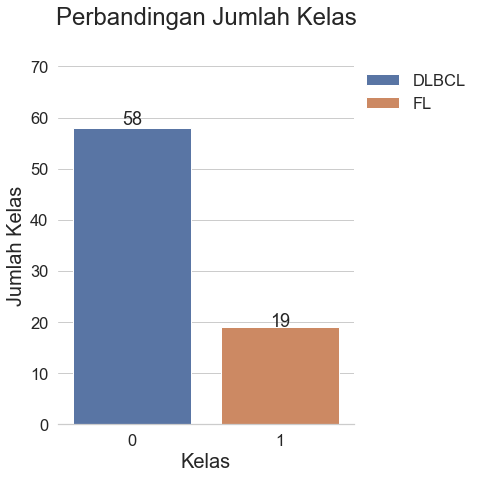

In [53]:
plt.figure(figsize=(7,7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.countplot(x=df.Class, hue=df.Class, dodge=False, data=df)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Kelas', fontsize=24, y=1.1)
p.set_ylabel('Jumlah Kelas', fontsize=20)
p.set_xlabel('Kelas', fontsize=20)
p.set_ylim(0, 70)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels=['DLBCL', 'FL'], frameon=False)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/JumlahClass.png')

In [9]:
encode = LabelEncoder()
df['Class'] = encode.fit_transform(df['Class'])
df.Class.value_counts()

0    58
1    19
Name: Class, dtype: int64

In [10]:
class_names = np.unique(df.Class)
class_names

array([0, 1])

In [11]:
X = df.drop(columns='Class').values
y = df.Class.values
print(Counter(y))

Counter({0: 58, 1: 19})


In [12]:
#normalisasi
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X)

0         1         2         3         4         5         6     \
0   0.935065  0.837229  0.535533  0.144361  0.528926  0.776097  0.703547   
1   0.907962  0.715152  0.469543  0.457143  0.426446  0.691377  1.000000   
2   0.904574  0.887446  0.629442  0.187970  0.527273  0.517398  0.554714   
3   0.923772  0.894372  0.593909  0.000000  0.575207  0.698941  0.676569   
4   0.941276  0.775758  0.510152  0.219549  0.742149  0.754917  0.682631   
..       ...       ...       ...       ...       ...       ...       ...   
72  0.909656  0.817316  0.540609  0.302256  0.859504  0.877458  0.849955   
73  0.678713  0.854545  0.543147  0.321805  0.854545  0.561271  0.604122   
74  0.831169  0.793939  0.350254  0.356391  0.839669  0.885023  0.822067   
75  0.763975  0.761039  0.228426  0.341353  0.661157  0.791225  0.763868   
76  0.925466  0.906494  0.380711  0.258647  0.408264  0.428139  0.723553   

        7         8         9     ...      7119      7120      7121      7122  \
0   0.668182  0.206941  0.428706  ...  0.273121  0.137020  0.879621  0.178820   
1   0.579545  0.393316  0.545798  ...  0.294798  0.703769  0.920379  0.537330   
2   0.413636  0.278920  0.347970  ...  0.326590  0.295174  0.894787  0.287804   
3   0.843182  0.205656  0.557129  ...  0.101156  0.389398  1.000000  0.253322   
4   0.365909  0.134961  0.461284  ...  0.182081  0.061641  0.937441  0.190209   
..       ...       ...       ...  ...       ...       ...       ...       ...   
72  0.856818  0.047558  0.575543  ...  0.686416  0.133145  0.704265  0.140541   
73  0.602273  0.475578  0.339471  ...  0.671965  0.241458  0.776777  0.082964   
74  0.640909  0.205656  0.516997  ...  0.498555  0.055477  0.943602  0.150902   
75  0.793182  0.271208  0.844665  ...  0.427746  0.042797  0.800000  0.084862   
76  0.495455  0.244216  0.431067  ...  0.500000  0.200951  0.886256  0.102895   

        7123      7124      7125      7126      7127      7128  
0   0.958457  0.148624  0.553937  0.902423  0.731809  0.982102  
1   0.960831  0.124159  0.400216  0.897839  0.713617  0.972286  
2   0.995846  0.156116  0.599245  0.925344  0.777547  0.962471  
3   0.930564  0.063303  0.529666  0.859201  0.730249  0.990762  
4   0.949555  0.121713  0.471413  0.910282  0.772869  0.983256  
..       ...       ...       ...       ...       ...       ...  
72  0.808309  0.074465  0.340885  0.727570  0.540541  0.776559  
73  0.852226  0.251682  0.820928  0.865750  0.701143  0.769630  
74  0.845697  0.060703  0.297735  0.755730  0.581601  0.814665  
75  0.874184  0.145260  0.441208  0.836935  0.629938  0.830254  
76  0.919881  0.260550  0.741640  0.899804  0.884615  0.967667  

[77 rows x 7129 columns]

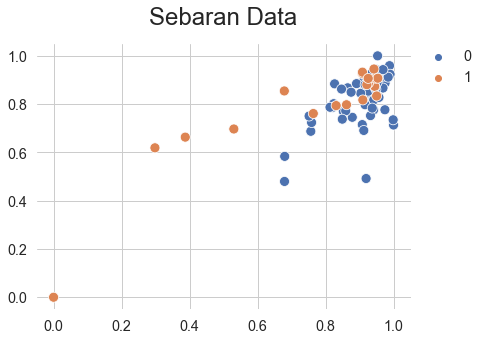

In [52]:
plt.figure(figsize=(7, 5))
plt.rcParams['figure.autolayout'] = True
sns.set_style('whitegrid')
p = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, s=100)
sns.despine(left=True, bottom=True)
p.set_title('Sebaran Data', fontsize=24, y=1.05)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/ScatterPlot.png')

# SELEKSI FITUR

### FOLD 2-10

In [26]:
fs_mdl = np.zeros(11)
fs_acc = np.zeros(11)
fs_prc = np.zeros(11)
fs_rcl = np.zeros(11)
fs_f1 = np.zeros(11)
ftr = np.zeros(11)
fs_pred = []
fs_act = []
fs_pos = []

X_train_fold = []
y_train_fold = []
X_test_fold = []
y_test_fold = []

for a in range(2, 11):
    print("FOLD :", a)

    #split menggunakan kfold
    folds = StratifiedKFold(n_splits=a, shuffle=True, random_state=42)

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for train_index, test_index in folds.split(X, y):
        X_train.append(X[train_index]), X_test.append(X[test_index]), y_train.append(y[train_index]), y_test.append(y[test_index])
    
    for i in range(folds.n_splits):
         print(Counter(y_train[i]))
    
    X_train_fold.append(X_train)
    y_train_fold.append(y_train)
    X_test_fold.append(X_test)
    y_test_fold.append(y_test)

    #modeling
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    #seleksi fitur BPSO
    def f_per_particle(m, alpha):
        total_features = X.shape[1]
        scores = np.zeros(folds.n_splits)

        for i in range(folds.n_splits):
            if np.count_nonzero(m) == 0:
                X_subset = X_train[i]
            else:
                X_subset = X_train[i][:,m==1]

            model.fit(X_subset, y_train[i])
            pred = model.predict(X_subset)
            scores[i] = accuracy_score(y_train[i], pred)

        P = np.mean(scores)

        j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
        return j

    def f(x, alpha=0.88):
        n_particles = x.shape[0]
        j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
        return np.array(j)

    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 30, 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)

    fs_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(folds.n_splits)
    acc_scr = np.zeros(folds.n_splits)
    prc_scr = np.zeros(folds.n_splits)
    rcl_scr = np.zeros(folds.n_splits)
    f1_scr = np.zeros(folds.n_splits)
    pred_scr = []
    act_scr = []

    for i in range(folds.n_splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)
        pred_scr.append(pred)
        act_scr.append(y_test[i])

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)


    #collect acc, prc, rcl, f1 BPSO
    fs_mdl[a-1] = np.mean(mdl_scr)
    fs_acc[a-1] = np.mean(acc_scr)
    fs_prc[a-1] = np.mean(prc_scr)
    fs_rcl[a-1] = np.mean(rcl_scr)
    fs_f1[a-1] = np.mean(f1_scr)
    ftr[a-1] = np.count_nonzero(pos)
    fs_pred.append(pred_scr)
    fs_act.append(act_scr)    


ind_fs = np.argmax(fs_acc)
print('---------- BPSO ----------')
print('Fold : ', ind_fs+1)
print('Accuracy Model : %0.4f'%(fs_mdl[ind_fs]))
print('Mean Accuracy: %0.4f'%(np.max(fs_acc)))
print('Mean Precision: %0.4f'%(fs_prc[ind_fs]))
print('Mean Recall: %0.4f'%(fs_rcl[ind_fs]))
print('Mean F1: %0.4f'%(fs_f1[ind_fs]))

2022-07-18 15:52:35,035 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 2
Counter({0: 29, 1: 9})
Counter({0: 29, 1: 10})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 15:52:38,393 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05731519147145462, best pos: [0 0 0 ... 1 0 0]
2022-07-18 15:52:38,462 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 3
Counter({0: 38, 1: 13})
Counter({0: 39, 1: 12})
Counter({0: 39, 1: 13})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 15:52:44,655 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05723102819469771, best pos: [0 1 0 ... 1 1 0]
2022-07-18 15:52:44,731 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 4
Counter({0: 43, 1: 14})
Counter({0: 43, 1: 15})
Counter({0: 44, 1: 14})
Counter({0: 44, 1: 14})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 15:52:53,591 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056574554635993826, best pos: [1 1 1 ... 0 0 1]
2022-07-18 15:52:53,684 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 5
Counter({0: 46, 1: 15})
Counter({0: 46, 1: 15})
Counter({0: 46, 1: 16})
Counter({0: 47, 1: 15})
Counter({0: 47, 1: 15})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 15:53:05,996 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05738252209286015, best pos: [1 0 0 ... 0 1 0]
2022-07-18 15:53:06,109 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 6
Counter({0: 48, 1: 16})
Counter({0: 48, 1: 16})
Counter({0: 48, 1: 16})
Counter({0: 48, 1: 16})
Counter({0: 49, 1: 15})
Counter({0: 49, 1: 16})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 15:53:19,478 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05723102819469771, best pos: [1 0 1 ... 0 1 1]
2022-07-18 15:53:19,602 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 7
Counter({0: 49, 1: 17})
Counter({0: 49, 1: 17})
Counter({0: 50, 1: 16})
Counter({0: 50, 1: 16})
Counter({0: 50, 1: 16})
Counter({0: 50, 1: 16})
Counter({0: 50, 1: 16})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 15:53:36,832 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056625052602047976, best pos: [1 1 1 ... 1 0 1]
2022-07-18 15:53:36,974 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 8
Counter({0: 50, 1: 17})
Counter({0: 50, 1: 17})
Counter({0: 51, 1: 16})
Counter({0: 51, 1: 16})
Counter({0: 51, 1: 16})
Counter({0: 51, 1: 17})
Counter({0: 51, 1: 17})
Counter({0: 51, 1: 17})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0562
2022-07-18 15:53:58,835 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05618740356291205, best pos: [0 1 1 ... 1 0 1]
2022-07-18 15:53:59,063 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 9
Counter({0: 51, 1: 17})
Counter({0: 51, 1: 17})
Counter({0: 51, 1: 17})
Counter({0: 51, 1: 17})
Counter({0: 52, 1: 16})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 15:54:30,874 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0574330200589143, best pos: [0 0 1 ... 1 0 1]
2022-07-18 15:54:31,131 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 10
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 17})
Counter({0: 52, 1: 18})
Counter({0: 53, 1: 17})
Counter({0: 53, 1: 17})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0569
2022-07-18 15:55:06,334 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056944873053724226, best pos: [0 0 0 ... 1 1 0]


---------- BPSO ----------
Fold :  7
Accuracy Model : 1.0000
Mean Accuracy: 0.8442
Mean Precision: 0.9306
Mean Recall: 0.8611
Mean F1: 0.8901


Confusion matrix, without normalization


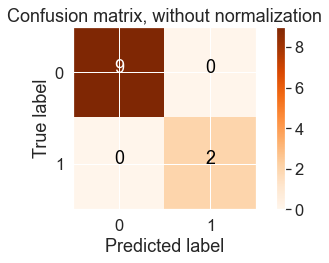

Confusion matrix, without normalization


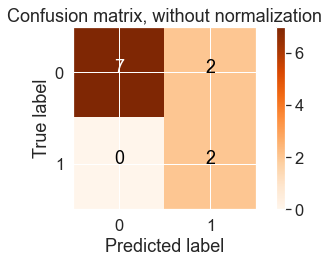

Confusion matrix, without normalization


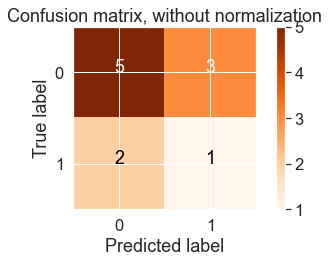

Confusion matrix, without normalization


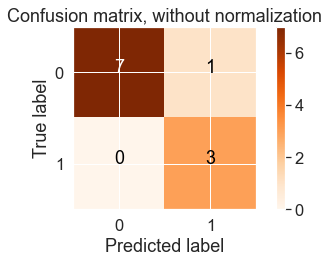

Confusion matrix, without normalization


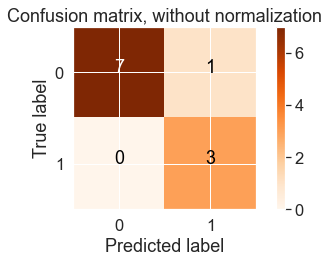

Confusion matrix, without normalization


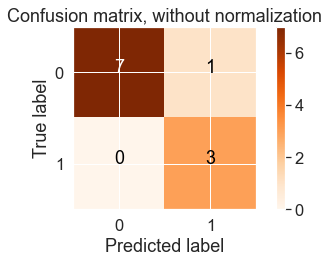

Confusion matrix, without normalization


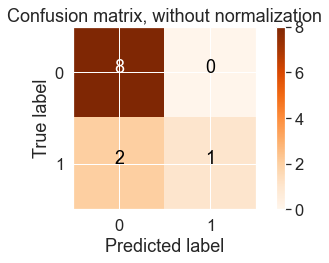

In [27]:
for i in range(ind_fs+1):
    plot_confusion_matrix(fs_pred[ind_fs-1][i], fs_act[ind_fs-1][i])

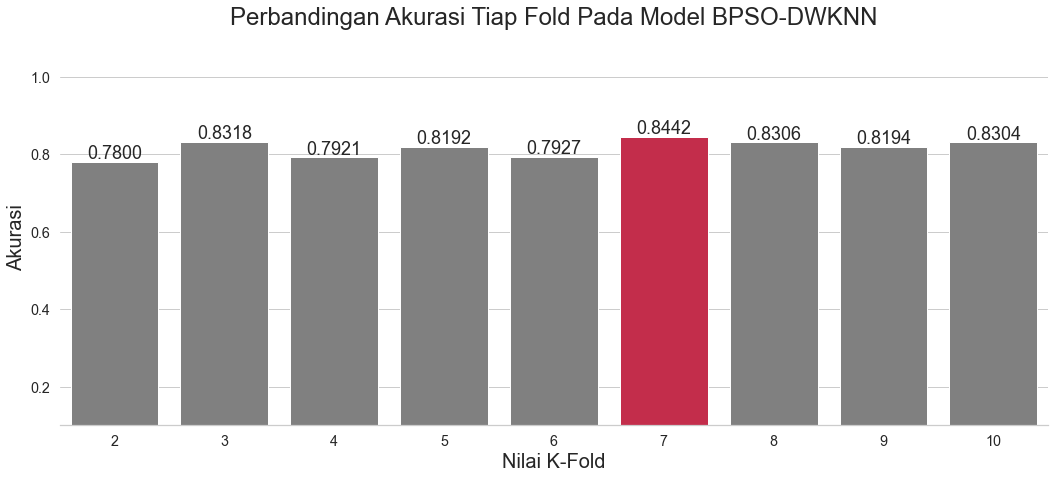

In [54]:
fold = [2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(15,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(fs_acc[1:10])) else 'crimson' for x in fs_acc[1:10]]
p = sns.barplot(x=fold, y=fs_acc[1:10], palette=clr)
sns.despine(left=True)
p.set_title('Perbandingan Akurasi Tiap Fold Pada Model BPSO-DWKNN', fontsize=24, y=1.05)
p.set_xlabel("Nilai K-Fold", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.5)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/FoldWithBPSO.png')

In [29]:
fld = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]
fold_fs_df = pd.DataFrame({'Fold': fld[1:10],
                       'AkurasiTrain': np.round(fs_mdl[1:10], 4),
                      'AkurasiTest': np.round(fs_acc[1:10], 4),
                      'Presisi': np.round(fs_prc[1:10], 4),
                      'Recall': np.round(fs_rcl[1:10], 4),
                      'F1-Score': np.round(fs_f1[1:10], 4),
                           'JumlahFitur': ftr[1:10],
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

fold_fs_df.style.set_table_styles(dfstyle).hide_index()

In [55]:
fs_pos_df = pd.DataFrame(fs_pos)
fs_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/DLBCLFoldPOS.csv')

## Pembagian Data

In [210]:
X_train = X_train_fold[ind_fs-1]
y_train = y_train_fold[ind_fs-1] 
X_test =  X_test_fold[ind_fs-1]
y_test = y_test_fold[ind_fs-1]

print(len(X_train), len(y_train), len(X_test), len(y_test))

7 7 7 7


## C1, C2, W

In [32]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')
splits = ind_fs+1

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

w = 0.9
c1 = [1, 1.25, 1.5, 1.75, 2]
c2 = [1, 1.25, 1.5, 1.75, 2]
wth, hgh = 5, 5
w0_acc = [[0 for x in range(wth)] for y in range(hgh)] 
w1_acc = [[0 for x in range(wth)] for y in range(hgh)]
c1c2_pos = []
for it in range(2):
    m = 0
    for _c1 in range(len(c1)):
        n = 0
        for _c2 in range(len(c2)):
                #inisiasiBPSO
                ps.discrete.BinaryPSO

                #executeBPSO
                options = {'c1': c1[_c1], 'c2': c2[_c2], 'w':w, 'k': 30, 'p':2}
                dimensions = X.shape[1]
                optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
                cost, pos = optimizer.optimize(f, iters=10, verbose=3)
                
                c1c2_pos.append(pos)

                #model
                model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

                mdl_scr = np.zeros(splits)
                acc_scr = np.zeros(splits)
                prc_scr = np.zeros(splits)
                rcl_scr = np.zeros(splits)
                f1_scr = np.zeros(splits)

                for i in range(splits):
                    X_train_selected = X_train[i][:,pos==1]
                    X_test_selected = X_test[i][:,pos==1]

                    #fit
                    model.fit(X_train_selected, y_train[i])

                    #predict
                    pred = model.predict(X_test_selected)

                    #accuracy
                    mdl_scr[i] = model.score(X_train_selected, y_train[i])
                    acc_scr[i] = accuracy_score(y_test[i], pred)
                    prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
                    rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
                    f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
                if w == 0.9:
                    w0_acc[m][n] = np.round(np.mean(acc_scr), 4)
                else:
                    w1_acc[m][n] = np.round(np.mean(acc_scr), 4)
                n+=1
                print('c1 = ', c1[_c1], 'c2 = ', c2[_c2], 'w = ', w)
                print('Dengan Seleksi Fitur BPSO')
                print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))
        m+=1
    w+=0.1

2022-07-18 15:55:44,822 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 15:56:07,849 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057601346612428106, best pos: [1 0 1 ... 0 0 1]
2022-07-18 15:56:08,051 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3707


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 15:56:30,956 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05739935474821153, best pos: [1 0 1 ... 0 1 0]
2022-07-18 15:56:31,160 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.9096 	 Recall: 0.8254 	 F1 Score: 0.8615 	 Fitur Terpilih: 3719


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 15:56:54,960 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05748351802496844, best pos: [1 0 1 ... 1 1 1]
2022-07-18 15:56:55,130 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9255 	 Recall: 0.8433 	 F1 Score: 0.8783 	 Fitur Terpilih: 3714


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 15:57:18,158 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05744985271426567, best pos: [0 0 1 ... 1 0 0]
2022-07-18 15:57:18,326 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.8989 	 Recall: 0.8611 	 F1 Score: 0.8744 	 Fitur Terpilih: 3716


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 15:57:41,537 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057012203675129755, best pos: [1 0 1 ... 1 0 0]
2022-07-18 15:57:41,705 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.8985 	 Recall: 0.879 	 F1 Score: 0.8838 	 Fitur Terpilih: 3742


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 15:58:04,843 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05780333847664469, best pos: [1 0 0 ... 0 0 1]
2022-07-18 15:58:05,013 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8571 	 Presisi:  0.9357 	 Recall: 0.879 	 F1 Score: 0.902 	 Fitur Terpilih: 3695


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 15:58:28,106 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05750035068031981, best pos: [0 1 0 ... 1 1 0]
2022-07-18 15:58:28,278 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.7792 	 Presisi:  0.8953 	 Recall: 0.8095 	 F1 Score: 0.8433 	 Fitur Terpilih: 3713


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 15:58:52,107 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05787066909805021, best pos: [0 1 1 ... 1 0 0]
2022-07-18 15:58:52,266 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9357 	 Recall: 0.8274 	 F1 Score: 0.8695 	 Fitur Terpilih: 3691


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 15:59:16,330 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057197362883994955, best pos: [0 1 1 ... 0 0 0]
2022-07-18 15:59:16,494 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9096 	 Recall: 0.8433 	 F1 Score: 0.8724 	 Fitur Terpilih: 3731


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 15:59:40,112 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057298358816103234, best pos: [0 1 1 ... 1 1 1]
2022-07-18 15:59:40,283 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9112 	 Recall: 0.8433 	 F1 Score: 0.8708 	 Fitur Terpilih: 3725


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 16:00:03,534 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05755084864637396, best pos: [0 0 1 ... 0 1 1]
2022-07-18 16:00:03,657 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9179 	 Recall: 0.879 	 F1 Score: 0.8937 	 Fitur Terpilih: 3710


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 16:00:19,693 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05709636695188666, best pos: [0 1 1 ... 0 1 0]
2022-07-18 16:00:19,805 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3737


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0564
2022-07-18 16:00:37,648 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056439893393182776, best pos: [1 0 1 ... 0 0 1]
2022-07-18 16:00:37,797 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3776


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 16:01:03,496 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05753401599102258, best pos: [1 1 0 ... 1 1 0]
2022-07-18 16:01:03,648 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.7922 	 Presisi:  0.8985 	 Recall: 0.8254 	 F1 Score: 0.8525 	 Fitur Terpilih: 3711


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 16:01:27,149 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05654088932529107, best pos: [1 1 0 ... 1 0 1]
2022-07-18 16:01:27,319 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9306 	 Recall: 0.8433 	 F1 Score: 0.8792 	 Fitur Terpilih: 3770


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 16:01:50,119 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05721419553934633, best pos: [1 1 0 ... 1 1 0]
2022-07-18 16:01:50,268 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.9183 	 Recall: 0.8274 	 F1 Score: 0.8635 	 Fitur Terpilih: 3730


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 16:02:12,895 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05768550988918501, best pos: [0 1 1 ... 1 1 0]
2022-07-18 16:02:13,040 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9036 	 Recall: 0.8611 	 F1 Score: 0.8752 	 Fitur Terpilih: 3702


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 16:02:35,892 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05682704446626455, best pos: [0 0 1 ... 1 1 1]
2022-07-18 16:02:36,048 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9128 	 Recall: 0.8611 	 F1 Score: 0.8817 	 Fitur Terpilih: 3753


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0567
2022-07-18 16:02:59,394 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05665871791275073, best pos: [1 1 1 ... 1 0 1]
2022-07-18 16:02:59,571 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8452 	 F1 Score: 0.871 	 Fitur Terpilih: 3763


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0567
2022-07-18 16:03:23,362 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056709215878804876, best pos: [1 1 1 ... 1 0 0]
2022-07-18 16:03:23,505 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9128 	 Recall: 0.879 	 F1 Score: 0.8913 	 Fitur Terpilih: 3760


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 16:03:47,539 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05780333847664469, best pos: [1 0 1 ... 1 1 1]
2022-07-18 16:03:47,698 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9179 	 Recall: 0.879 	 F1 Score: 0.8937 	 Fitur Terpilih: 3695


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 16:04:10,879 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05763501192313087, best pos: [0 0 0 ... 1 0 0]
2022-07-18 16:04:11,033 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9255 	 Recall: 0.8611 	 F1 Score: 0.8892 	 Fitur Terpilih: 3705


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 16:04:34,812 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056759713844859026, best pos: [1 1 0 ... 0 0 1]
2022-07-18 16:04:34,978 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.8989 	 Recall: 0.8433 	 F1 Score: 0.8635 	 Fitur Terpilih: 3757


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 16:04:58,031 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05654088932529107, best pos: [0 0 0 ... 0 0 0]
2022-07-18 16:04:58,197 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.8985 	 Recall: 0.8611 	 F1 Score: 0.8742 	 Fitur Terpilih: 3770


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0564
2022-07-18 16:05:23,008 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05637256277177724, best pos: [0 0 1 ... 1 0 1]
2022-07-18 16:05:23,182 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9128 	 Recall: 0.8611 	 F1 Score: 0.8817 	 Fitur Terpilih: 3780


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 16:05:47,479 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057971665030158506, best pos: [1 0 1 ... 1 1 0]
2022-07-18 16:05:47,652 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8571 	 Presisi:  0.9433 	 Recall: 0.8611 	 F1 Score: 0.8975 	 Fitur Terpilih: 3685


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 16:06:11,062 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0572478608500491, best pos: [1 1 0 ... 1 0 0]
2022-07-18 16:06:11,224 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9179 	 Recall: 0.879 	 F1 Score: 0.8937 	 Fitur Terpilih: 3728


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0562
2022-07-18 16:06:34,343 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056221068873614805, best pos: [0 1 1 ... 1 0 0]
2022-07-18 16:06:34,510 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3789


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 16:06:56,442 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057113199607238034, best pos: [1 0 1 ... 1 0 0]
2022-07-18 16:06:56,555 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.9036 	 Recall: 0.8452 	 F1 Score: 0.8645 	 Fitur Terpilih: 3736


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 16:07:13,034 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056625052602047976, best pos: [0 0 0 ... 0 1 0]
2022-07-18 16:07:13,148 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.8969 	 Recall: 0.8452 	 F1 Score: 0.8645 	 Fitur Terpilih: 3765


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 16:07:31,836 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057298358816103234, best pos: [1 1 0 ... 0 1 0]
2022-07-18 16:07:31,999 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9128 	 Recall: 0.8611 	 F1 Score: 0.8817 	 Fitur Terpilih: 3725


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 16:07:55,491 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057332024126806005, best pos: [0 0 0 ... 0 1 0]
2022-07-18 16:07:55,652 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9128 	 Recall: 0.8611 	 F1 Score: 0.8817 	 Fitur Terpilih: 3723


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 16:08:18,195 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05763501192313087, best pos: [0 1 0 ... 1 0 1]
2022-07-18 16:08:18,354 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9306 	 Recall: 0.8433 	 F1 Score: 0.8792 	 Fitur Terpilih: 3705


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0567
2022-07-18 16:08:41,042 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056709215878804876, best pos: [1 0 0 ... 1 0 1]
2022-07-18 16:08:41,201 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3760


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 16:09:05,292 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05652405666993968, best pos: [1 0 1 ... 1 0 1]
2022-07-18 16:09:05,459 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.8985 	 Recall: 0.8611 	 F1 Score: 0.8742 	 Fitur Terpilih: 3771


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 16:09:29,584 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05763501192313087, best pos: [0 1 1 ... 0 0 0]
2022-07-18 16:09:29,810 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9306 	 Recall: 0.8433 	 F1 Score: 0.8792 	 Fitur Terpilih: 3705


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 16:09:54,165 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057012203675129755, best pos: [0 0 0 ... 0 1 0]
2022-07-18 16:09:54,360 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9306 	 Recall: 0.8433 	 F1 Score: 0.8792 	 Fitur Terpilih: 3742


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 16:10:18,868 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05738252209286015, best pos: [1 1 1 ... 1 1 1]
2022-07-18 16:10:19,024 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3720


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 16:10:43,718 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05704586898583251, best pos: [0 0 1 ... 0 0 1]
2022-07-18 16:10:43,890 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3740


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 16:11:08,816 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057012203675129755, best pos: [0 1 0 ... 0 0 1]
2022-07-18 16:11:08,989 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9306 	 Recall: 0.8611 	 F1 Score: 0.8901 	 Fitur Terpilih: 3742


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 16:11:32,574 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05704586898583251, best pos: [1 1 1 ... 0 0 1]
2022-07-18 16:11:32,751 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.8985 	 Recall: 0.8433 	 F1 Score: 0.8633 	 Fitur Terpilih: 3740


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 16:11:55,917 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056625052602047976, best pos: [0 0 1 ... 0 0 0]
2022-07-18 16:11:56,100 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.7922 	 Presisi:  0.8985 	 Recall: 0.8274 	 F1 Score: 0.8526 	 Fitur Terpilih: 3765


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 16:12:19,213 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056978538364426984, best pos: [0 1 0 ... 1 1 0]
2022-07-18 16:12:19,386 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9306 	 Recall: 0.8611 	 F1 Score: 0.8901 	 Fitur Terpilih: 3744


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 16:12:42,661 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05707953429653528, best pos: [1 0 1 ... 1 0 0]
2022-07-18 16:12:42,850 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9036 	 Recall: 0.8631 	 F1 Score: 0.8754 	 Fitur Terpilih: 3738


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 16:13:05,732 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05707953429653528, best pos: [0 1 0 ... 0 0 1]
2022-07-18 16:13:05,894 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3738


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 16:13:28,983 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057517183335671206, best pos: [0 0 0 ... 0 1 0]
2022-07-18 16:13:29,149 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9163 	 Recall: 0.8611 	 F1 Score: 0.8826 	 Fitur Terpilih: 3712


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 16:13:52,285 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057332024126806005, best pos: [1 0 0 ... 1 1 1]
2022-07-18 16:13:52,451 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8442 	 Presisi:  0.9255 	 Recall: 0.8611 	 F1 Score: 0.8892 	 Fitur Terpilih: 3723


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 16:14:15,345 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05677654650021041, best pos: [0 0 0 ... 1 0 1]
2022-07-18 16:14:15,513 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9036 	 Recall: 0.879 	 F1 Score: 0.8861 	 Fitur Terpilih: 3756


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0563
2022-07-18 16:14:38,689 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05633889746107448, best pos: [1 0 1 ... 1 1 0]
2022-07-18 16:14:38,861 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9163 	 Recall: 0.8452 	 F1 Score: 0.8718 	 Fitur Terpilih: 3782


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 16:15:01,982 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0572478608500491, best pos: [1 1 0 ... 1 1 0]


c1 =  2 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8571 	 Presisi:  0.9357 	 Recall: 0.879 	 F1 Score: 0.902 	 Fitur Terpilih: 3728


In [33]:
w0_df = pd.DataFrame(w0_acc)
w0_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w0_df.index = ['1', '1.25', '1.5', '1.75', '2']

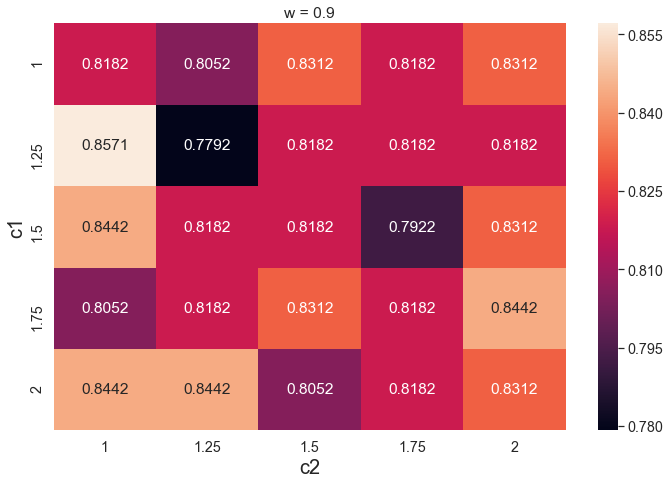

In [56]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w0 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w0_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w0.set_title(label= 'w = 0.9');
par_w0.set_xlabel('c2', fontdict=ft)
par_w0.set_ylabel('c1', fontdict=ft)
p_fig = par_w0.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/C1C2W09.png')

In [35]:
# w0_acc.reverse()

In [36]:
w1_df = pd.DataFrame(w1_acc)
w1_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w1_df.index = ['1', '1.25', '1.5', '1.75', '2']

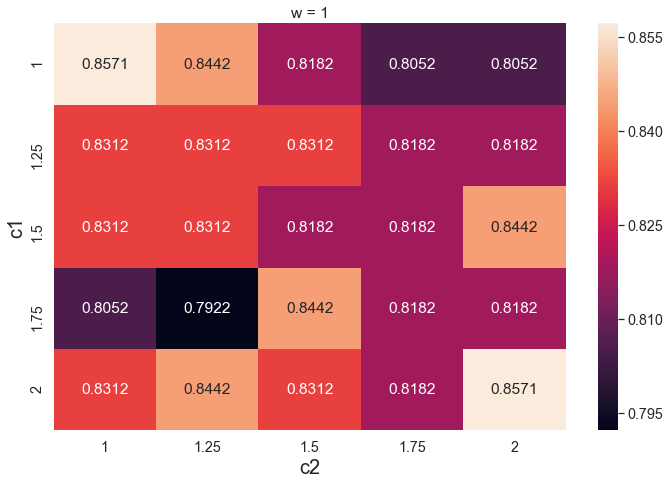

In [57]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w1 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w1_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w1.set_title(label= 'w = 1');
par_w1.set_xlabel('c2', fontdict=ft)
par_w1.set_ylabel('c1', fontdict=ft)
p_fig = par_w1.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/C1C2W1.png')

In [139]:
c1c2_pos_df = pd.DataFrame(c1c2_pos)
c1c2_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/DLBCLC1C2POS.csv')

## Population

In [215]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

prt = [10, 20, 30, 50]

pop_mdl = np.zeros(len(prt))
pop_acc = np.zeros(len(prt))
pop_prc = np.zeros(len(prt))
pop_rcl = np.zeros(len(prt))
pop_f1 = np.zeros(len(prt))
pop_pos = []

for k in range(len(prt)):
    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': prt[k], 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=prt[k], dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)
    
    pop_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(splits)
    acc_scr = np.zeros(splits)
    prc_scr = np.zeros(splits)
    rcl_scr = np.zeros(splits)
    f1_scr = np.zeros(splits)

    for i in range(splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
    
    pop_mdl[k] = np.mean(mdl_scr)
    pop_acc[k] = np.mean(acc_scr)
    pop_prc[k] = np.mean(prc_scr)
    pop_rcl[k] = np.mean(rcl_scr)
    pop_f1[k] = np.mean(f1_scr)   
    
    print('Population:', prt[k])
    print('Dengan Seleksi Fitur BPSO')
    print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))

2022-07-18 20:11:57,252 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 20:12:02,787 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05744985271426567, best pos: [0 0 1 ... 0 1 1]
2022-07-18 20:12:02,909 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 10
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8312 	 Presisi:  0.9306 	 Recall: 0.8452 	 F1 Score: 0.8794 	 Fitur Terpilih: 3716


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 20:12:14,029 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05652405666993968, best pos: [1 1 1 ... 1 0 1]
2022-07-18 20:12:14,154 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 20
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8571 	 Presisi:  0.9357 	 Recall: 0.879 	 F1 Score: 0.902 	 Fitur Terpilih: 3771


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0567
2022-07-18 20:12:28,758 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056709215878804876, best pos: [1 1 0 ... 1 0 1]
2022-07-18 20:12:28,899 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 50, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 30
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8052 	 Presisi:  0.8846 	 Recall: 0.8611 	 F1 Score: 0.8669 	 Fitur Terpilih: 3760


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 20:12:53,400 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0572478608500491, best pos: [0 0 1 ... 1 0 1]


Population: 50
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8182 	 Presisi:  0.9128 	 Recall: 0.8433 	 F1 Score: 0.8709 	 Fitur Terpilih: 3728


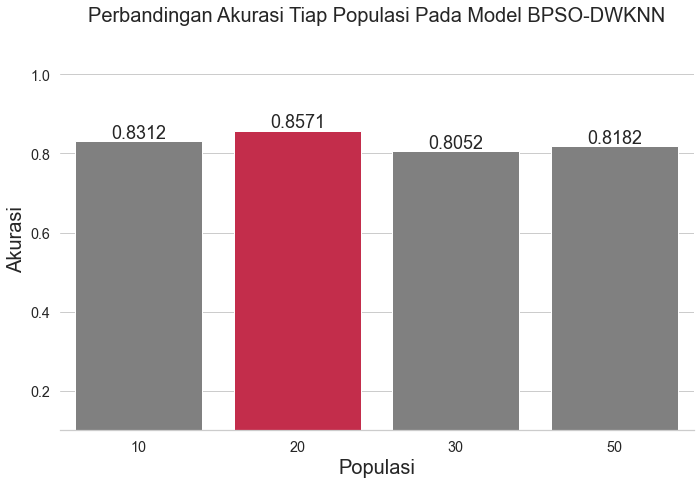

In [216]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(pop_acc)) else 'crimson' for x in pop_acc]
p = sns.barplot(x=prt, y=pop_acc, palette=clr)
p.set_title('Perbandingan Akurasi Tiap Populasi Pada Model BPSO-DWKNN', fontsize=20, y=1.05)
sns.despine(left=True)
p.set_xlabel("Populasi", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Populasi.png')

In [217]:
pop = [10, 20, 30, 50]
pop_ftr = [np.count_nonzero(pop_pos[0]), np.count_nonzero(pop_pos[1]), np.count_nonzero(pop_pos[2]), np.count_nonzero(pop_pos[3])]
pop_df = pd.DataFrame({'Populasi': pop,
                       'AkurasiTrain': np.round(pop_mdl, 4),
                      'AkurasiTest': np.round(pop_acc, 4),
                      'Presisi': np.round(pop_prc, 4),
                      'Recall': np.round(pop_rcl, 4),
                      'F1-Score': np.round(pop_f1, 4),
                       'JumlahFitur': pop_ftr,
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

pop_df.style.set_table_styles(dfstyle).hide_index()

In [218]:
pop_pos_df = pd.DataFrame(pop_pos)
pop_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/DLBCLPopPOS.csv')

In [279]:
col = df.columns[1:].values
fitur_df = pd.DataFrame(col[pop_pos[1]==1])
fitur_n_df = pd.DataFrame(col[pop_pos[1]==0])
fitur_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/DLBCL(FiturTerpilih).csv')
fitur_n_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/DLBCL(FiturDihapus).csv')

# KLASIFIKASI

In [280]:
kfld_mdl = []
kfld_acc = []
kfld_prc = []
kfld_rcl = []
kfld_f1 = []
kfld_pred = []
kfld_act = []

kfld_d_mdl = []
kfld_d_acc = []
kfld_d_prc = []
kfld_d_rcl = []
kfld_d_f1 = []
kfld_d_pred = []
kfld_d_act = []

In [281]:
print(np.argmax(pop_acc))
for a in range(9):
    print("FOLD :", a+2)
    X_train = X_train_fold[a]
    y_train = y_train_fold[a] 
    X_test =  X_test_fold[a]
    y_test = y_test_fold[a]

    print(len(X_train), len(y_train), len(X_test), len(y_test))
    
    range_k0 = []

    kf_mdl = []
    kf_acc = []
    kf_prc = []
    kf_rcl = []
    kf_f1 = []
    kf_pred = []
    kf_act = []

    kfd_mdl = []
    kfd_acc = []
    kfd_prc = []
    kfd_rcl = []
    kfd_f1 = []
    kfd_pred = []
    kfd_act = []

    for k in range(1, 21):
        
        range_k0.append(k)
        model = DistanceWeightedKNN(n_neighbors=k, algorithm='brute')
        
        # BPSO-DWKNN
        mdl_scr = np.zeros(a+2)
        acc_scr = np.zeros(a+2)
        prc_scr = np.zeros(a+2)
        rcl_scr = np.zeros(a+2)
        f1_scr = np.zeros(a+2)
        
        pred_scr = []
        act_scr = []
        for i in range(a+2):
            
            X_train_selected = X_train[i][:,pop_pos[np.argmax(pop_acc)]==1]
            X_test_selected = X_test[i][:,pop_pos[np.argmax(pop_acc)]==1]

            #fit
            model.fit(X_train_selected, y_train[i])

            #predict
            pred = model.predict(X_test_selected)
            pred_scr.append(pred)
            act_scr.append(y_test[i])

            #accuracy
            mdl_scr[i] = model.score(X_train_selected, y_train[i])
            acc_scr[i] = accuracy_score(y_test[i], pred)
            prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
            rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
            f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
        
        # DWKNN
        _mdl_scr = np.zeros(a+2)
        _acc_scr = np.zeros(a+2)
        _prc_scr = np.zeros(a+2)
        _rcl_scr = np.zeros(a+2)
        _f1_scr = np.zeros(a+2)
            
        _pred_scr = []
        _act_scr = []
        for i in range(a+2):
            #fit
            model.fit(X_train[i], y_train[i])

            #predict
            pred = model.predict(X_test[i])
            _pred_scr.append(pred)
            _act_scr.append(y_test[i])

            #accuracy
            _mdl_scr[i] = model.score(X_train[i], y_train[i])
            _acc_scr[i] = accuracy_score(y_test[i], pred)
            _prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
            _rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
            _f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)

        # BPSO-DWKNN
        kf_mdl.append(np.round(np.mean(mdl_scr),4))
        kf_acc.append(np.round(np.mean(acc_scr),4))
        kf_prc.append(np.round(np.mean(prc_scr),4))
        kf_rcl.append(np.round(np.mean(rcl_scr),4))
        kf_f1.append(np.round(np.mean(f1_scr),4))
        kf_pred.append(pred_scr)
        kf_act.append(act_scr)

        # DWKNN
        kfd_mdl.append(np.round(np.mean(_mdl_scr),4))
        kfd_acc.append(np.round(np.mean(_acc_scr),4))
        kfd_prc.append(np.round(np.mean(_prc_scr),4))
        kfd_rcl.append(np.round(np.mean(_rcl_scr),4))
        kfd_f1.append(np.round(np.mean(_f1_scr),4))
        kfd_pred.append(_pred_scr)
        kfd_act.append(_act_scr)
    print(len(kfld_acc))
    if len(kfld_acc) < 9:
        # BPSO-DWKNN 
        kfld_mdl.append(kf_mdl)
        kfld_acc.append(kf_acc)
        kfld_prc.append(kf_prc)
        kfld_rcl.append(kf_rcl)
        kfld_f1.append(kf_f1)
        kfld_pred.append(kf_pred)
        kfld_act.append(kf_act)

        # DWKNN
        kfld_d_mdl.append(kfd_mdl)
        kfld_d_acc.append(kfd_acc)
        kfld_d_prc.append(kfd_prc)
        kfld_d_rcl.append(kfd_rcl)
        kfld_d_f1.append(kfd_f1)
        kfld_d_pred.append(kfd_pred)
        kfld_d_act.append(kfd_act)
    else:
        for z in range(len(kf_mdl)):
            # BPSO-DWKNN 
            kfld_mdl[a].append(kf_mdl[z])
            kfld_acc[a].append(kf_acc[z])
            kfld_prc[a].append(kf_prc[z])
            kfld_rcl[a].append(kf_rcl[z])
            kfld_f1[a].append(kf_f1[z])
            kfld_pred[a].append(kf_pred[z])
            kfld_act[a].append(kf_act[z])

            # DWKNN
            kfld_d_mdl[a].append(kfd_mdl[z])
            kfld_d_acc[a].append(kfd_acc[z])
            kfld_d_prc[a].append(kfd_prc[z])
            kfld_d_rcl[a].append(kfd_rcl[z])
            kfld_d_f1[a].append(kfd_f1[z])
            kfld_d_pred[a].append(kfd_pred[z])
            kfld_d_act[a].append(kfd_act[z])

1
FOLD : 2
2 2 2 2
0
FOLD : 3
3 3 3 3
1
FOLD : 4
4 4 4 4
2
FOLD : 5
5 5 5 5
3
FOLD : 6
6 6 6 6
4
FOLD : 7
7 7 7 7
5
FOLD : 8
8 8 8 8
6
FOLD : 9
9 9 9 9
7
FOLD : 10
10 10 10 10
8


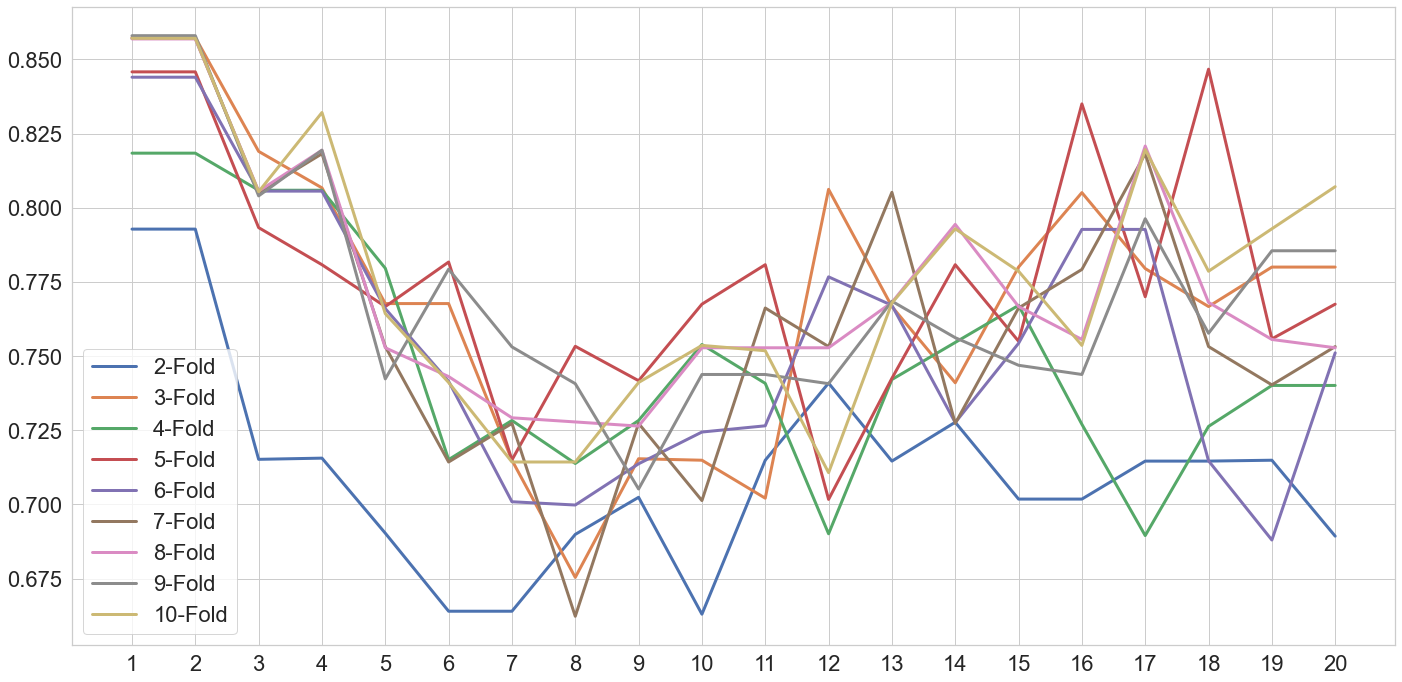

In [283]:
plt.figure(figsize=(20,10))
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=3)
    p.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [284]:
val_k = []

max_mdl = []
max_akr = []
max_prc = []
max_rcl = []
max_f1 = []
for i in range(9):
    print('FOLD:', i+2, '\t K:', np.argmax(kfld_acc[i])+1, '\t ACC:', np.max(kfld_acc[i]), '\t JUMLAH FITUR:', (np.count_nonzero(pop_pos[np.argmax(pop_acc)])))
    val_k.append(np.argmax(kfld_acc[i])+1)
    max_mdl.append(kfld_mdl[i][np.argmax(kfld_acc[i])])
    max_akr.append(np.max(kfld_acc[i]))
    max_prc.append(kfld_prc[i][np.argmax(kfld_acc[i])])
    max_rcl.append(kfld_rcl[i][np.argmax(kfld_acc[i])])
    max_f1.append(kfld_f1[i][np.argmax(kfld_acc[i])])

FOLD: 2 	 K: 1 	 ACC: 0.7928 	 JUMLAH FITUR: 3771
FOLD: 3 	 K: 1 	 ACC: 0.8574 	 JUMLAH FITUR: 3771
FOLD: 4 	 K: 1 	 ACC: 0.8184 	 JUMLAH FITUR: 3771
FOLD: 5 	 K: 18 	 ACC: 0.8467 	 JUMLAH FITUR: 3771
FOLD: 6 	 K: 1 	 ACC: 0.844 	 JUMLAH FITUR: 3771
FOLD: 7 	 K: 1 	 ACC: 0.8571 	 JUMLAH FITUR: 3771
FOLD: 8 	 K: 1 	 ACC: 0.8569 	 JUMLAH FITUR: 3771
FOLD: 9 	 K: 1 	 ACC: 0.858 	 JUMLAH FITUR: 3771
FOLD: 10 	 K: 1 	 ACC: 0.8571 	 JUMLAH FITUR: 3771


In [320]:
print(kfld_acc[0][0], kfld_prc[0][0], kfld_rcl[0][0], kfld_f1[0][0])
print(kfld_acc[0][1], kfld_prc[0][1], kfld_rcl[0][1], kfld_f1[0][1])
print('===================================')
print(kfld_acc[1][0], kfld_prc[1][0], kfld_rcl[1][0], kfld_f1[1][0])
print(kfld_acc[1][1], kfld_prc[1][1], kfld_rcl[1][1], kfld_f1[1][1])
print('===================================')
print(kfld_acc[2][0], kfld_prc[2][0], kfld_rcl[2][0], kfld_f1[2][0])
print(kfld_acc[2][1], kfld_prc[2][1], kfld_rcl[2][1], kfld_f1[2][1])
print('===================================')
print(kfld_acc[4][0], kfld_prc[4][0], kfld_rcl[4][0], kfld_f1[4][0])
print(kfld_acc[4][1], kfld_prc[4][1], kfld_rcl[4][1], kfld_f1[4][1])
print('===================================')
print(kfld_acc[5][0], kfld_prc[5][0], kfld_rcl[5][0], kfld_f1[5][0])
print(kfld_acc[5][1], kfld_prc[5][1], kfld_rcl[5][1], kfld_f1[5][1])
print('===================================')
print(kfld_acc[6][0], kfld_prc[6][0], kfld_rcl[6][0], kfld_f1[6][0])
print(kfld_acc[6][1], kfld_prc[6][1], kfld_rcl[6][1], kfld_f1[6][1])
print('===================================')
print(kfld_acc[7][0], kfld_prc[7][0], kfld_rcl[7][0], kfld_f1[7][0])
print(kfld_acc[7][1], kfld_prc[7][1], kfld_rcl[7][1], kfld_f1[7][1])
print('===================================')
print(kfld_acc[8][0], kfld_prc[8][0], kfld_rcl[8][0], kfld_f1[8][0])
print(kfld_acc[8][1], kfld_prc[8][1], kfld_rcl[8][1], kfld_f1[8][1])

0.7928 0.9195 0.7931 0.8503
0.7928 0.9195 0.7931 0.8503
0.8574 0.9131 0.8974 0.9046
0.8574 0.9131 0.8974 0.9046
0.8184 0.9 0.8643 0.8765
0.8184 0.9 0.8643 0.8765
0.844 0.9008 0.8981 0.8963
0.844 0.9008 0.8981 0.8963
0.8571 0.9357 0.879 0.902
0.8571 0.9357 0.879 0.902
0.8569 0.9308 0.8795 0.901
0.8569 0.9308 0.8795 0.901
0.858 0.9321 0.881 0.8976
0.858 0.9321 0.881 0.8976
0.8571 0.93 0.8833 0.9015
0.8571 0.93 0.8833 0.9015


In [285]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bpdw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_k, 
              'AkurasiTrain': max_mdl,
              'AkurasiTest': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1_Score': max_f1,
              'Jumlah Fitur':(np.count_nonzero(pop_pos[np.argmax(pop_acc)]))
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

bpdw_df.style.set_table_styles(dfstyle).hide_index()

In [286]:
val_d_k = []

max_d_mdl = []
max_d_akr = []
max_d_prc = []
max_d_rcl = []
max_d_f1 = []

for i in range(9):
    print('FOLD:', i+2, 'K:', np.argmax(kfld_d_acc[i])+1, 'ACC:', np.max(kfld_d_acc[i]))
    val_d_k.append(np.argmax(kfld_d_acc[i])+1)
    max_d_mdl.append(kfld_d_mdl[i][np.argmax(kfld_d_acc[i])])
    max_d_akr.append(np.max(kfld_d_acc[i]))
    max_d_prc.append(kfld_d_prc[i][np.argmax(kfld_d_acc[i])])
    max_d_rcl.append(kfld_d_rcl[i][np.argmax(kfld_d_acc[i])])
    max_d_f1.append(kfld_d_f1[i][np.argmax(kfld_d_acc[i])])

FOLD: 2 K: 1 ACC: 0.7669
FOLD: 3 K: 1 ACC: 0.8446
FOLD: 4 K: 1 ACC: 0.7921
FOLD: 5 K: 1 ACC: 0.8325
FOLD: 6 K: 1 ACC: 0.8184
FOLD: 7 K: 1 ACC: 0.8182
FOLD: 8 K: 1 ACC: 0.8306
FOLD: 9 K: 1 ACC: 0.8302
FOLD: 10 K: 1 ACC: 0.8304


In [325]:
print(kfld_d_acc[0][0], kfld_d_prc[0][0], kfld_d_rcl[0][0], kfld_d_f1[0][0])
print(kfld_d_acc[0][1], kfld_d_prc[0][1], kfld_d_rcl[0][1], kfld_d_f1[0][1])
print('===================================')
print(kfld_d_acc[1][0], kfld_d_prc[1][0], kfld_d_rcl[1][0], kfld_d_f1[1][0])
print(kfld_d_acc[1][1], kfld_d_prc[1][1], kfld_d_rcl[1][1], kfld_d_f1[1][1])
print('===================================')
print(kfld_d_acc[2][0], kfld_d_prc[2][0], kfld_d_rcl[2][0], kfld_d_f1[2][0])
print(kfld_d_acc[2][1], kfld_d_prc[2][1], kfld_d_rcl[2][1], kfld_d_f1[2][1])
print('===================================')
print(kfld_d_acc[3][0], kfld_d_prc[3][0], kfld_d_rcl[3][0], kfld_d_f1[3][0])
print(kfld_d_acc[3][1], kfld_d_prc[3][1], kfld_d_rcl[3][1], kfld_d_f1[3][1])
print('===================================')
print(kfld_d_acc[4][0], kfld_d_prc[4][0], kfld_d_rcl[4][0], kfld_d_f1[4][0])
print(kfld_d_acc[4][1], kfld_d_prc[4][1], kfld_d_rcl[4][1], kfld_d_f1[4][1])
print('===================================')
print(kfld_d_acc[5][0], kfld_d_prc[5][0], kfld_d_rcl[5][0], kfld_d_f1[5][0])
print(kfld_d_acc[5][1], kfld_d_prc[5][1], kfld_d_rcl[5][1], kfld_d_f1[5][1])
print('===================================')
print(kfld_d_acc[6][0], kfld_d_prc[6][0], kfld_d_rcl[6][0], kfld_d_f1[6][0])
print(kfld_d_acc[6][1], kfld_d_prc[6][1], kfld_d_rcl[6][1], kfld_d_f1[6][1])
print('===================================')
print(kfld_d_acc[7][0], kfld_d_prc[7][0], kfld_d_rcl[7][0], kfld_d_f1[7][0])
print(kfld_d_acc[7][1], kfld_d_prc[7][1], kfld_d_rcl[7][1], kfld_d_f1[7][1])
print('===================================')
print(kfld_d_acc[8][0], kfld_d_prc[8][0], kfld_d_rcl[8][0], kfld_d_f1[8][0])
print(kfld_d_acc[8][1], kfld_d_prc[8][1], kfld_d_rcl[8][1], kfld_d_f1[8][1])

0.7669 0.901 0.7759 0.8308
0.7669 0.901 0.7759 0.8308
0.8446 0.8965 0.8974 0.8965
0.8446 0.8965 0.8974 0.8965
0.7921 0.8865 0.8476 0.8575
0.7921 0.8865 0.8476 0.8575
0.8325 0.8962 0.8803 0.8859
0.8325 0.8962 0.8803 0.8859
0.8184 0.8882 0.8796 0.8781
0.8184 0.8882 0.8796 0.8781
0.8182 0.9128 0.8433 0.8709
0.8182 0.9128 0.8433 0.8709
0.8306 0.9122 0.8616 0.8817
0.8306 0.9122 0.8616 0.8817
0.8302 0.9136 0.8624 0.8791
0.8302 0.9136 0.8624 0.8791
0.8304 0.9157 0.8667 0.8829
0.8304 0.9157 0.8667 0.8829


In [287]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
dw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_d_k, 
              'AkurasiTrain': max_d_mdl,
              'AkurasiTest': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1_Score': max_d_f1,
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

dw_df.style.set_table_styles(dfstyle).hide_index()

In [327]:
kfld_d_acc[3]

[0.8325,
 0.8325,
 0.78,
 0.7542,
 0.7533,
 0.755,
 0.7675,
 0.7283,
 0.7417,
 0.7283,
 0.7417,
 0.7558,
 0.7417,
 0.7542,
 0.73,
 0.7817,
 0.82,
 0.7808,
 0.7425,
 0.7283]

### Excel K BPSO-DWKNN

In [288]:
acc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_acc[0],
              'Fold 3': kfld_acc[1],
              'Fold 4': kfld_acc[2],
              'Fold 5': kfld_acc[3],
              'Fold 6': kfld_acc[4],
              'Fold 7': kfld_acc[5],
              'Fold 8': kfld_acc[6],
              'Fold 9': kfld_acc[7],
              'Fold 10': kfld_acc[8],
              })

prc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_prc[0],
              'Fold 3': kfld_prc[1],
              'Fold 4': kfld_prc[2],
              'Fold 5': kfld_prc[3],
              'Fold 6': kfld_prc[4],
              'Fold 7': kfld_prc[5],
              'Fold 8': kfld_prc[6],
              'Fold 9': kfld_prc[7],
              'Fold 10': kfld_prc[8],
              })

rcl_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_rcl[0],
              'Fold 3': kfld_rcl[1],
              'Fold 4': kfld_rcl[2],
              'Fold 5': kfld_rcl[3],
              'Fold 6': kfld_rcl[4],
              'Fold 7': kfld_rcl[5],
              'Fold 8': kfld_rcl[6],
              'Fold 9': kfld_rcl[7],
              'Fold 10': kfld_rcl[8],
              })

f1_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_f1[0],
              'Fold 3': kfld_f1[1],
              'Fold 4': kfld_f1[2],
              'Fold 5': kfld_f1[3],
              'Fold 6': kfld_f1[4],
              'Fold 7': kfld_f1[5],
              'Fold 8': kfld_f1[6],
              'Fold 9': kfld_f1[7],
              'Fold 10': kfld_f1[8],
              })

### Excel K DWKNN

In [289]:
acc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_acc[0],
              'Fold 3': kfld_d_acc[1],
              'Fold 4': kfld_d_acc[2],
              'Fold 5': kfld_d_acc[3],
              'Fold 6': kfld_d_acc[4],
              'Fold 7': kfld_d_acc[5],
              'Fold 8': kfld_d_acc[6],
              'Fold 9': kfld_d_acc[7],
              'Fold 10': kfld_d_acc[8],
              })

prc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_prc[0],
              'Fold 3': kfld_d_prc[1],
              'Fold 4': kfld_d_prc[2],
              'Fold 5': kfld_d_prc[3],
              'Fold 6': kfld_d_prc[4],
              'Fold 7': kfld_d_prc[5],
              'Fold 8': kfld_d_prc[6],
              'Fold 9': kfld_d_prc[7],
              'Fold 10': kfld_d_prc[8],
              })

rcl_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_rcl[0],
              'Fold 3': kfld_d_rcl[1],
              'Fold 4': kfld_d_rcl[2],
              'Fold 5': kfld_d_rcl[3],
              'Fold 6': kfld_d_rcl[4],
              'Fold 7': kfld_d_rcl[5],
              'Fold 8': kfld_d_rcl[6],
              'Fold 9': kfld_d_rcl[7],
              'Fold 10': kfld_d_rcl[8],
              })

f1_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_f1[0],
              'Fold 3': kfld_d_f1[1],
              'Fold 4': kfld_d_f1[2],
              'Fold 5': kfld_d_f1[3],
              'Fold 6': kfld_d_f1[4],
              'Fold 7': kfld_d_f1[5],
              'Fold 8': kfld_d_f1[6],
              'Fold 9': kfld_d_f1[7],
              'Fold 10': kfld_d_f1[8],
              })

## BPSO-DWKNN PLOT

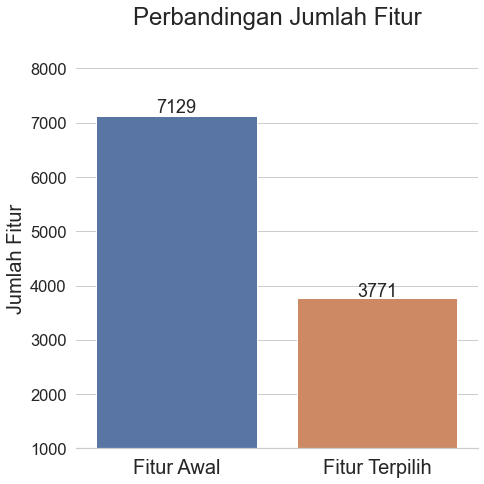

In [290]:
ax_y = [X.shape[1], np.count_nonzero(pop_pos[np.argmax(pop_acc)])]
ax_x = ['Fitur Awal', 'Fitur Terpilih']
plt.figure(figsize=(7,7))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.barplot(x=ax_x, y=ax_y)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Fitur', fontsize=24, y=1.1)
p.set_ylabel("Jumlah Fitur", fontsize = 20)
p.set_xticklabels(ax_x, fontsize = 20)
p.set_ylim(1000, 8000)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Jumlah Fitur.png')

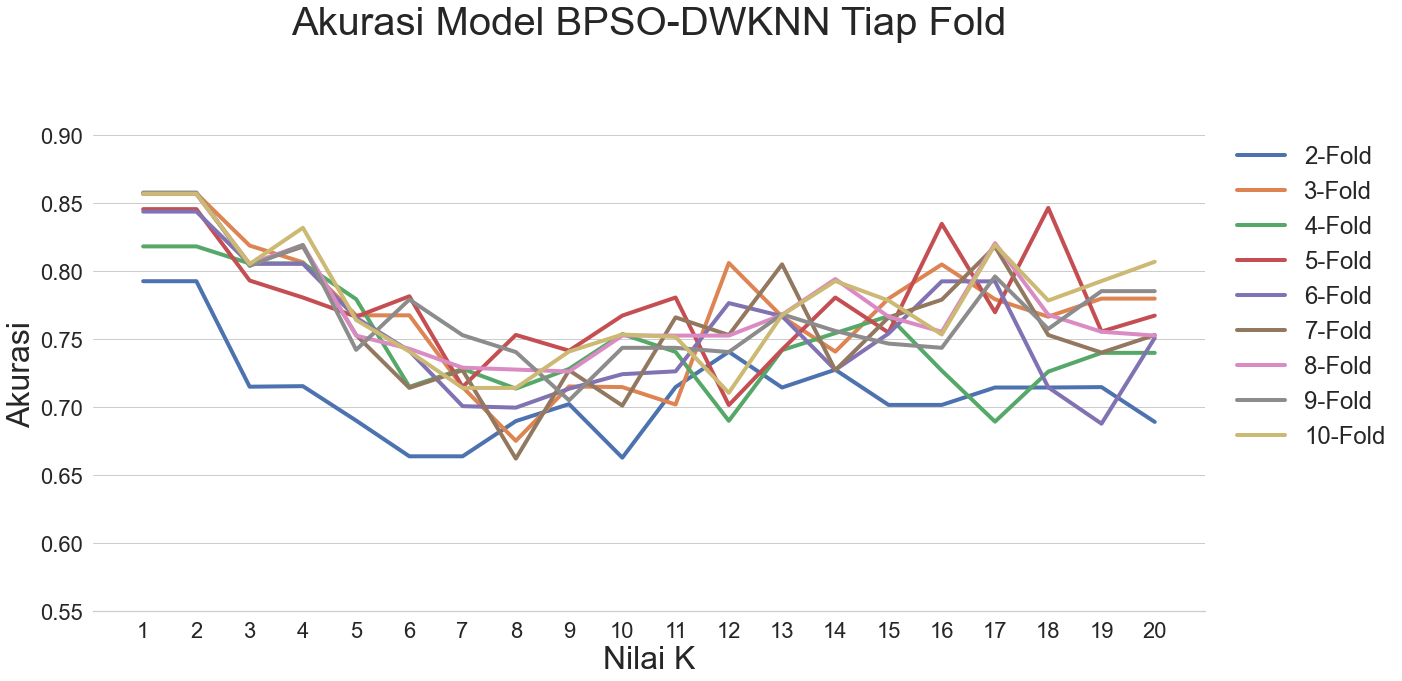

In [291]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
p.set_title('Akurasi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Akurasi BPSO-DW Tiap Fold.png')

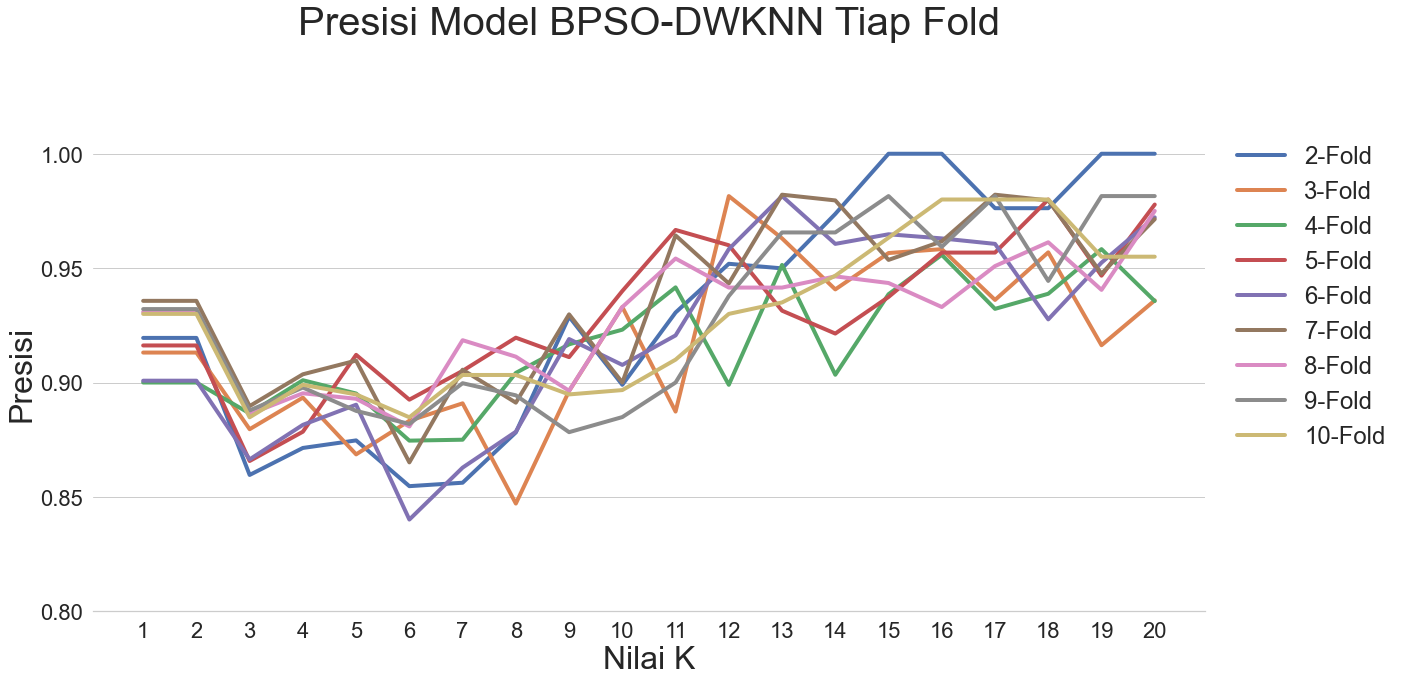

In [292]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Presisi BPSO-DW Tiap Fold.png')

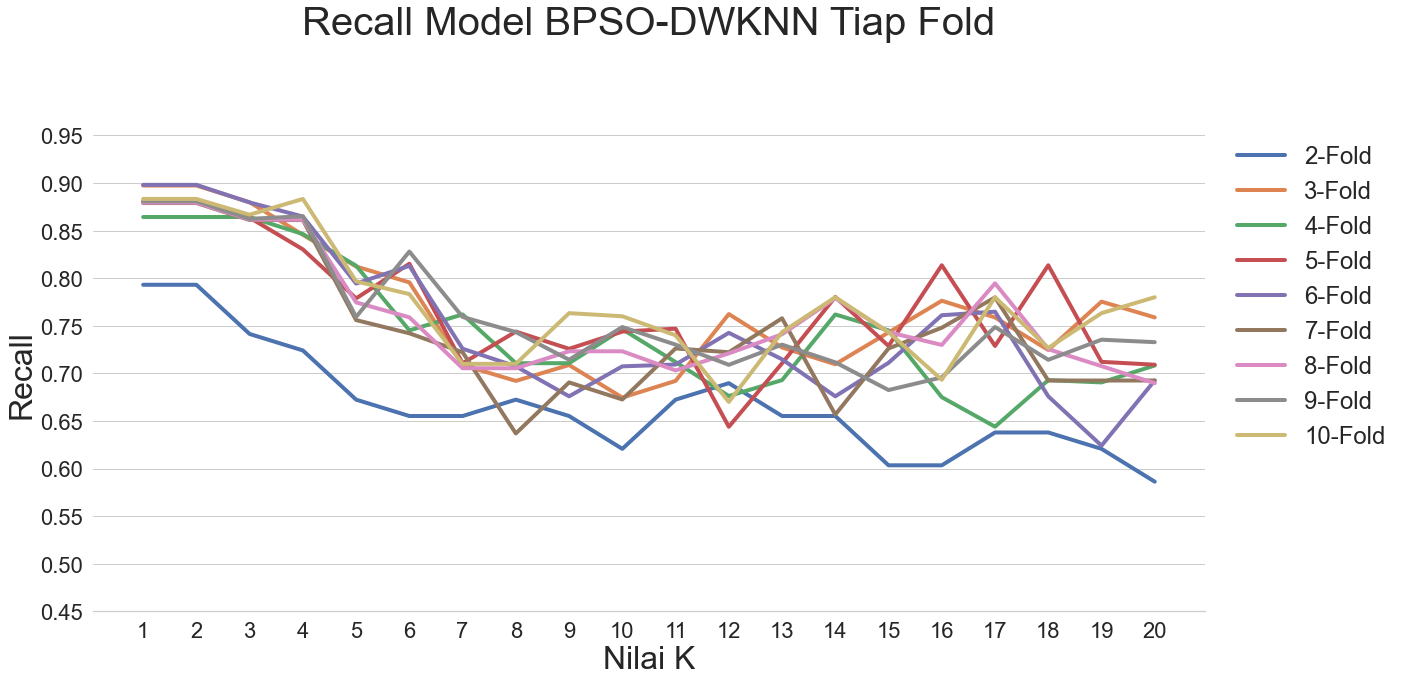

In [293]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Recall BPSO-DW Tiap Fold.png')

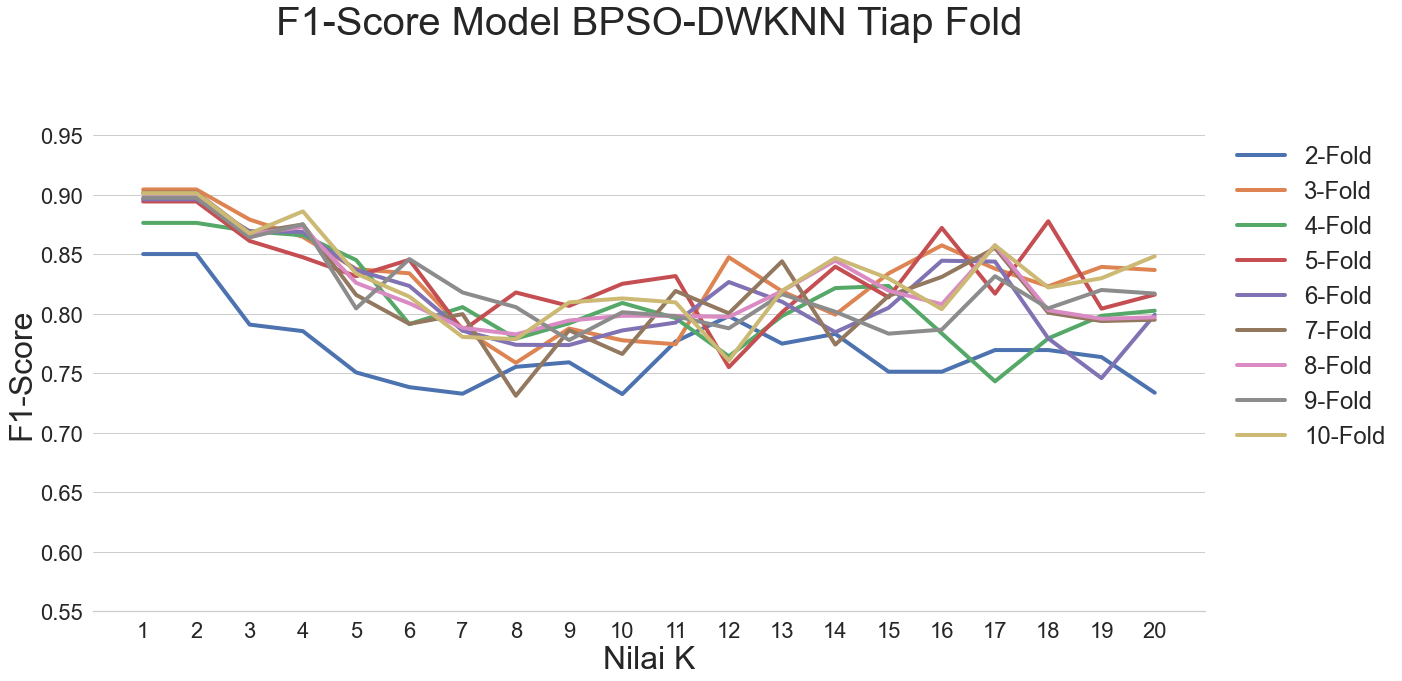

In [294]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/F1-Score BPSO-DW Tiap Fold.png')

In [295]:
kfld_acc[7][1]

0.858

Confusion matrix, without normalization


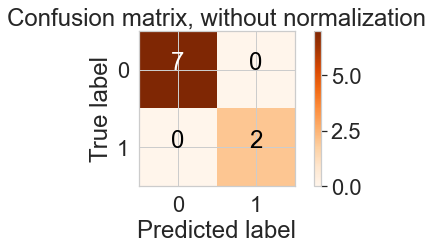

Confusion matrix, without normalization


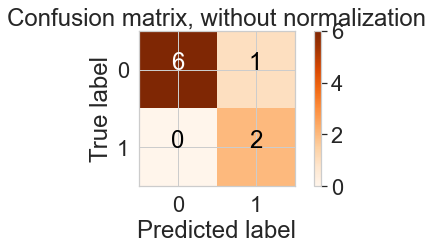

Confusion matrix, without normalization


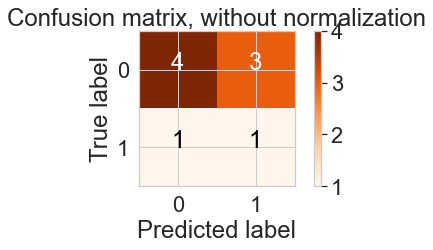

Confusion matrix, without normalization


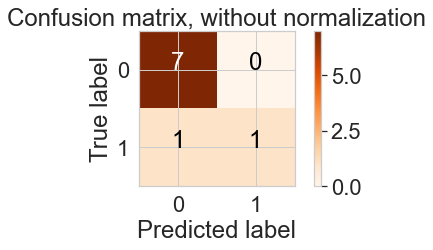

Confusion matrix, without normalization


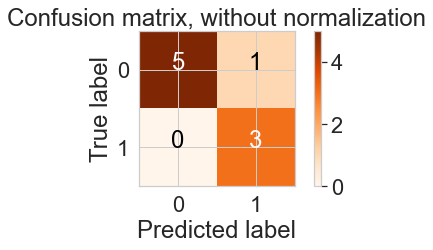

Confusion matrix, without normalization


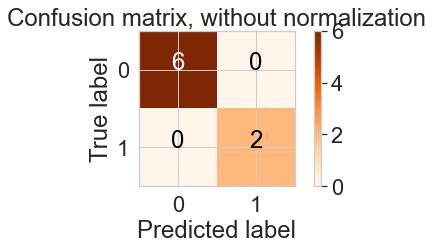

Confusion matrix, without normalization


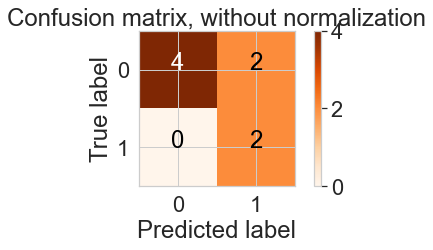

Confusion matrix, without normalization


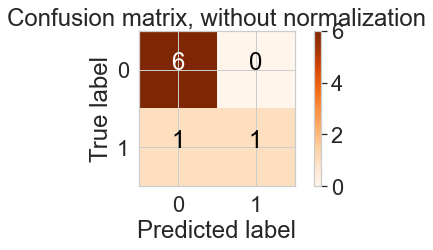

Confusion matrix, without normalization


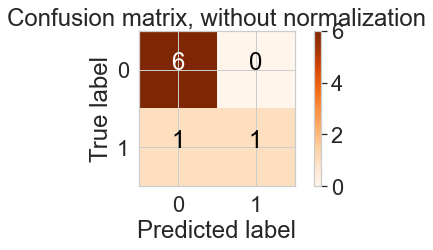

In [296]:
for i in range(9):
    plot_confusion_matrix(kfld_pred[7][1][i], kfld_act[7][1][i])

## DWKNN PLOT

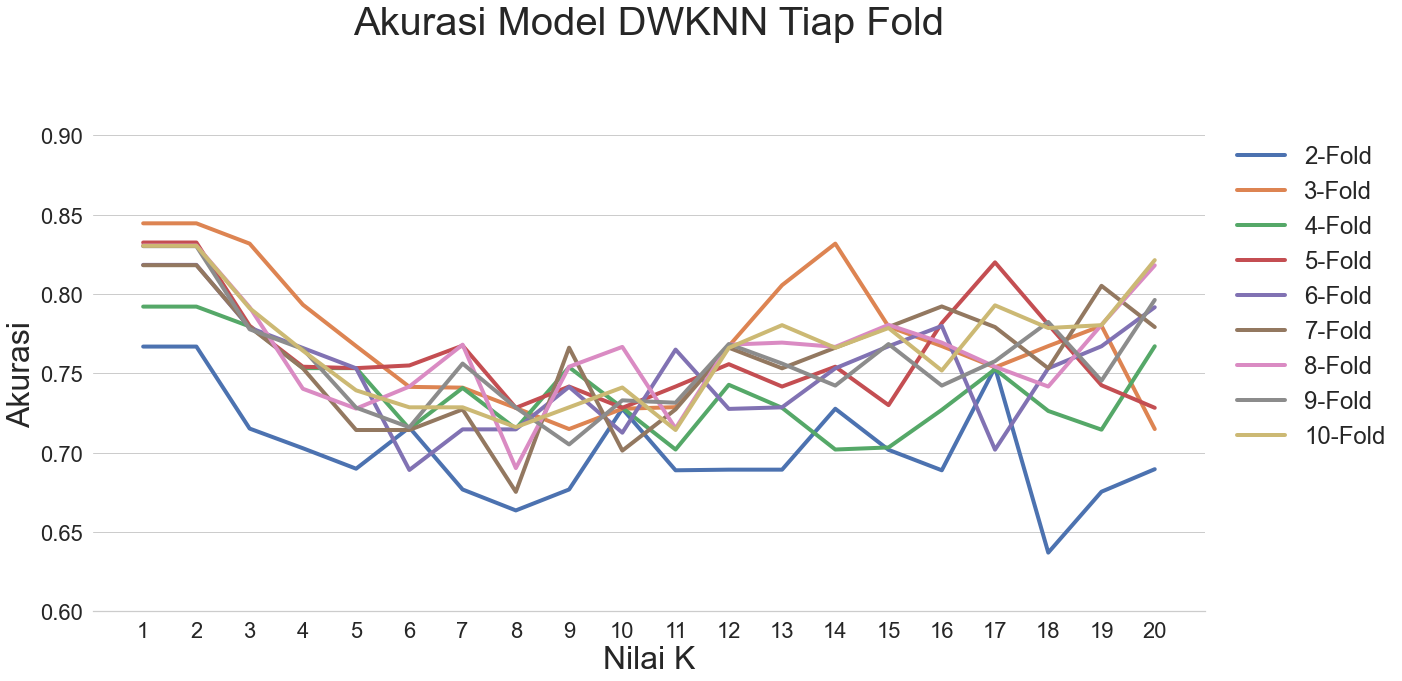

In [297]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
p.set_title('Akurasi Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Akurasi DW Tiap Fold.png')

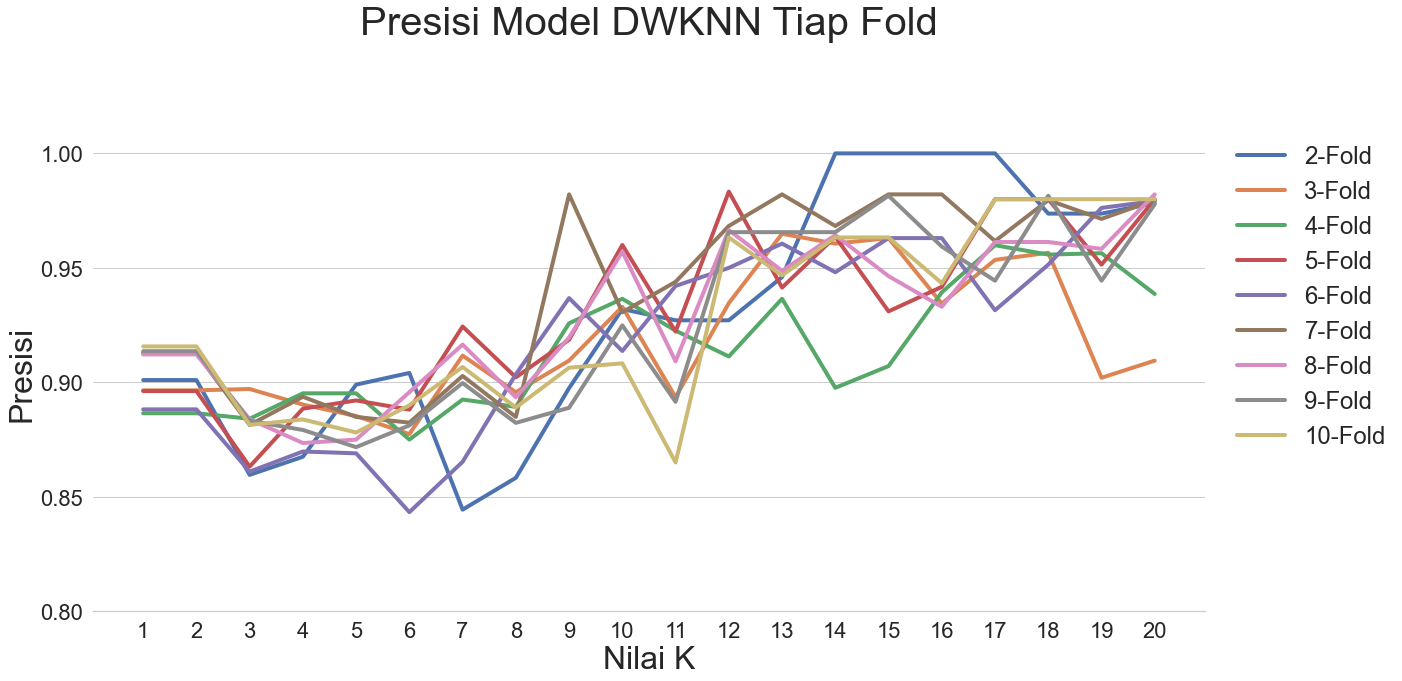

In [298]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
p.set_title('Presisi Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Presisi DW Tiap Fold.png')

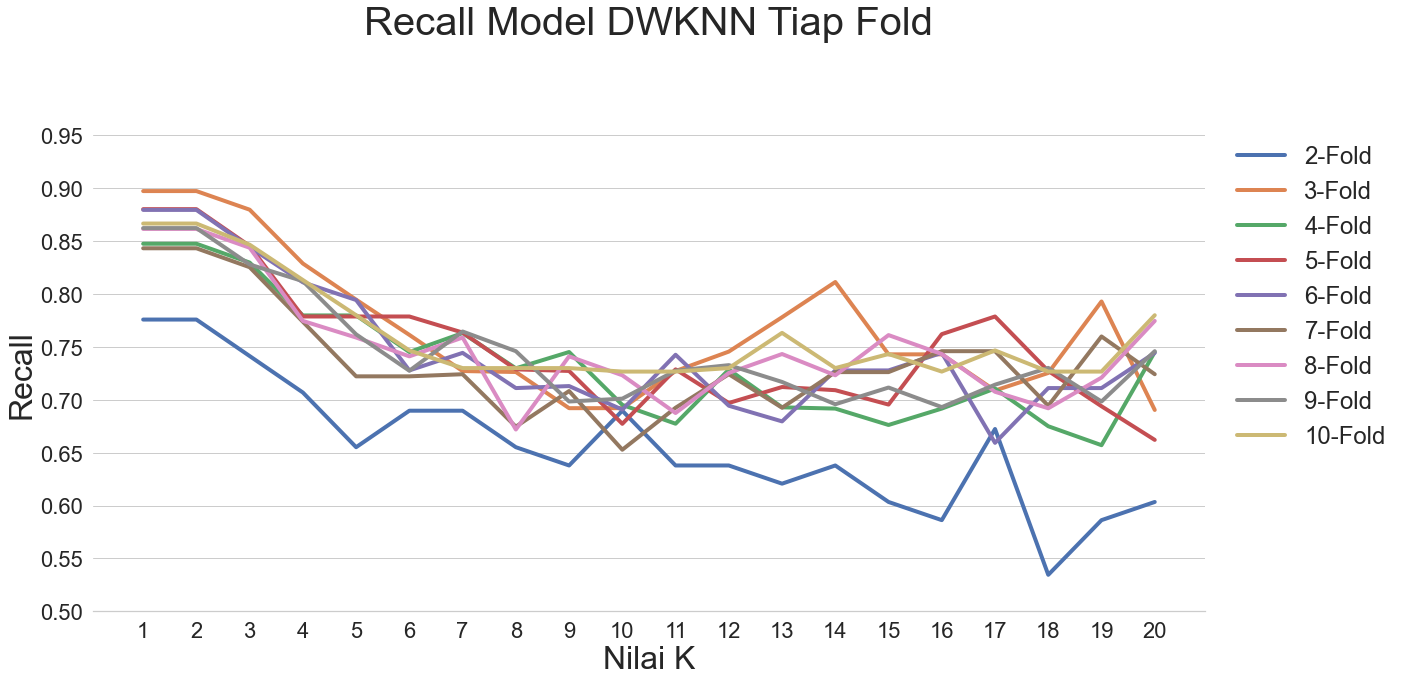

In [299]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('Recall Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Recall DW Tiap Fold.png')

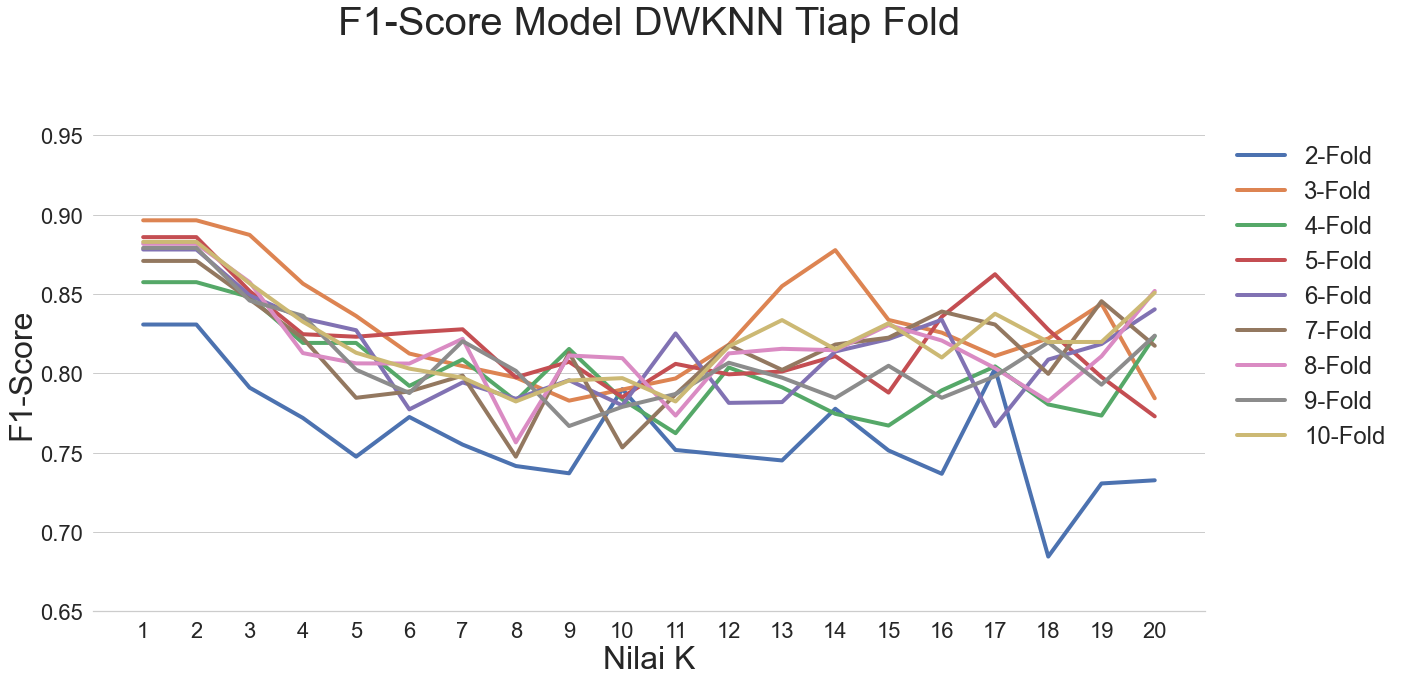

In [300]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('F1-Score Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/F1-Score DW Tiap Fold.png')

Confusion matrix, without normalization


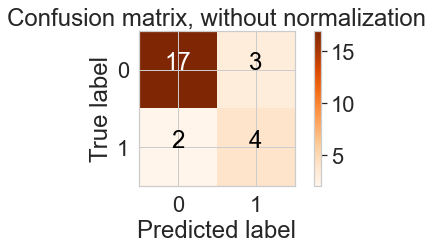

Confusion matrix, without normalization


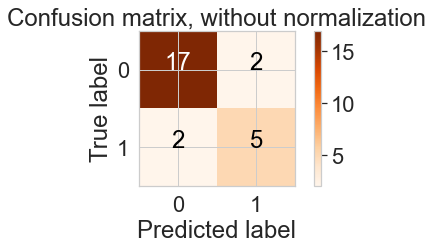

Confusion matrix, without normalization


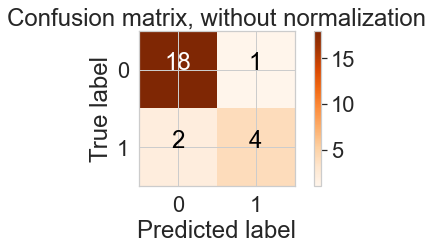

In [301]:
for i in range(3):
    plot_confusion_matrix(kfld_d_pred[1][1][i], kfld_d_act[1][1][i])

In [302]:
kfld_d_acc[1][1]

0.8446

## BPSO-DWKNN vs DWKNN Plot

In [303]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hsl01_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_k, 
              'Akurasi': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1-Score': max_f1,
              'Model': 'BPSO-DWKNN',
              })
hsl02_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_d_k, 
              'Akurasi': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1-Score': max_d_f1,
              'Model': 'DWKNN',
              })
hsl03_df = hsl01_df.append(hsl02_df)

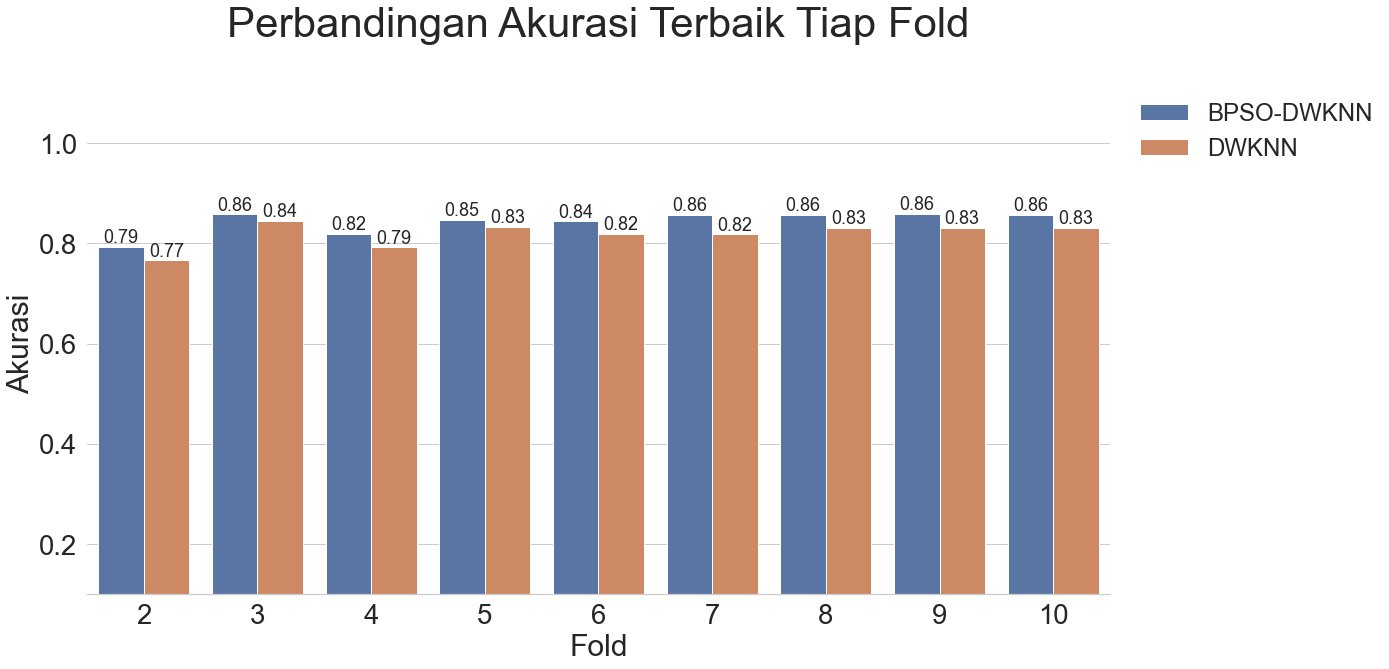

In [304]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Akurasi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Perbandingan Akurasi Terbaik Tiap Fold.png')

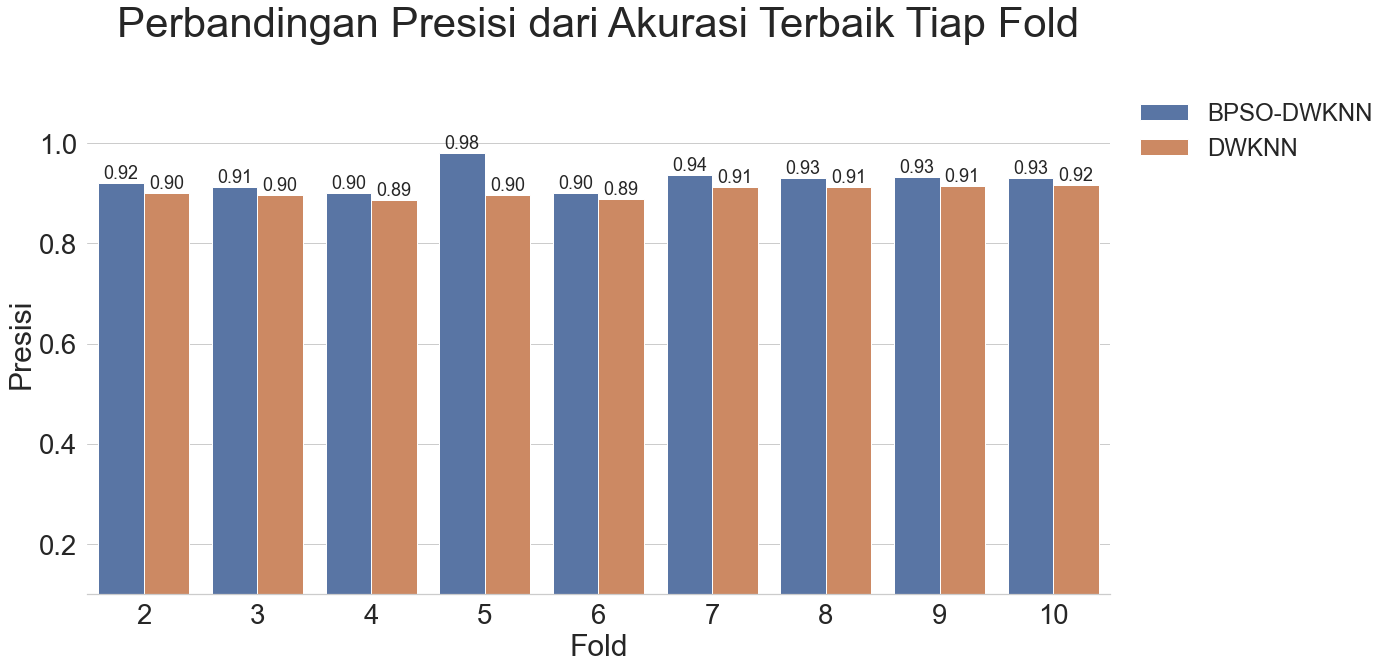

In [305]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Presisi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Presisi dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Perbandingan Presisi dari Akurasi Terbaik Tiap Fold.png')

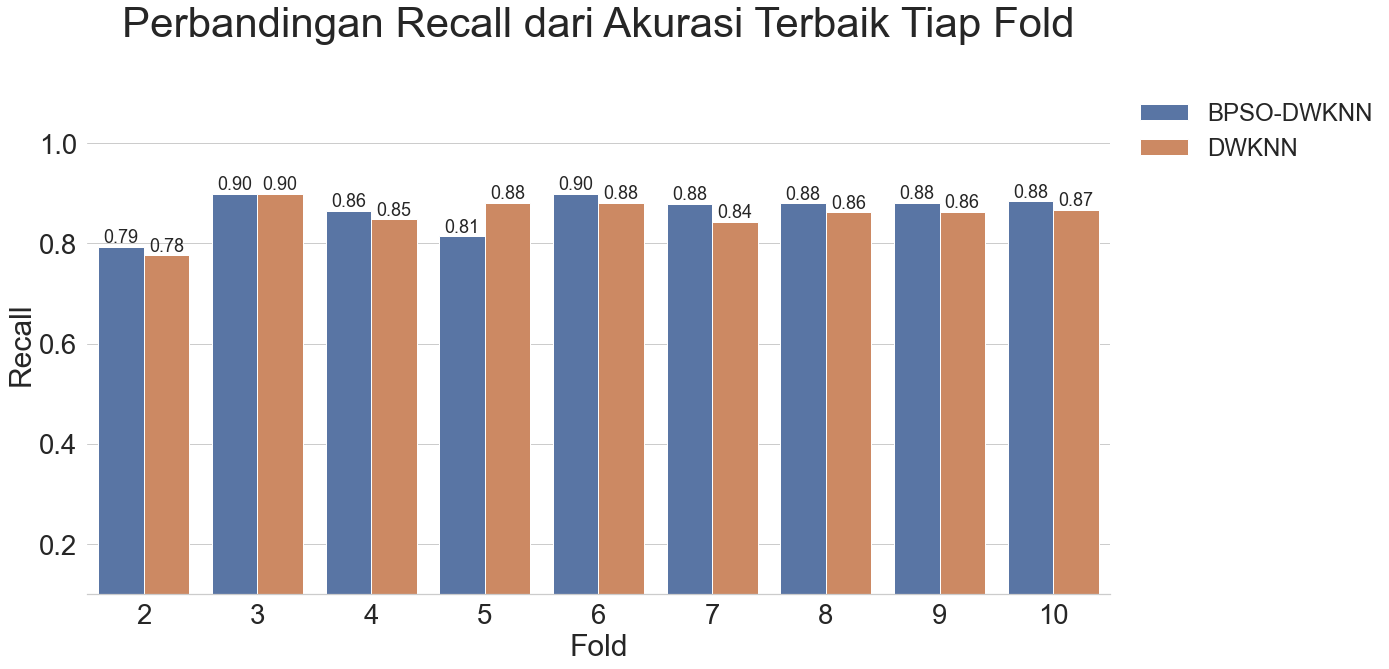

In [306]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Recall', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Recall dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Perbandingan Recall dari Akurasi Terbaik Tiap Fold.png')

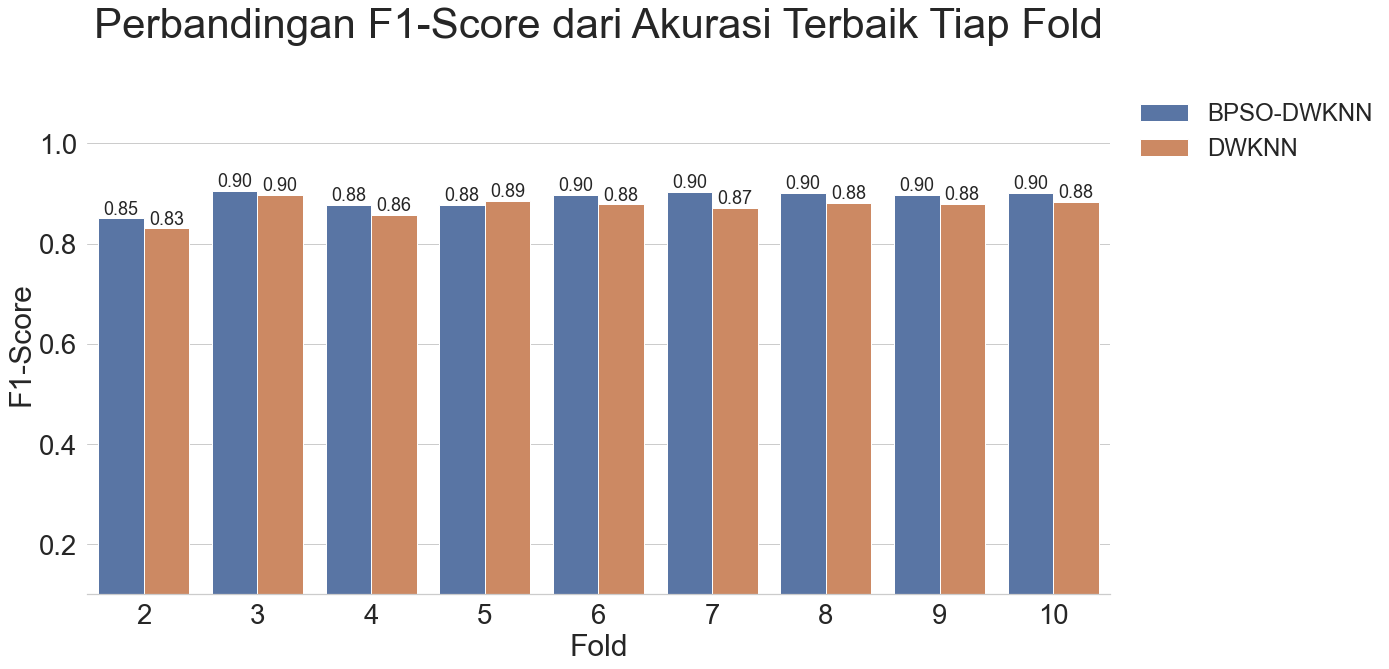

In [307]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='F1-Score', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold.png')

In [308]:
max_all_df = pd.DataFrame({'Matriks':['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'Akurasi', 'Presisi', 'Recall', 'F1-Score'],
                        'Nilai':[np.max(bpdw_df.AkurasiTest.values), 
                                 bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)],                        
                                 bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 np.max(dw_df.AkurasiTest.values), 
                                 dw_df.Presisi[np.argmax(dw_df.AkurasiTest.values)], 
                                 dw_df.Recall[np.argmax(dw_df.AkurasiTest.values)],
                                 dw_df.F1_Score[np.argmax(dw_df.AkurasiTest.values)]],
                        'Model':['BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'DWKNN', 'DWKNN', 'DWKNN', 'DWKNN'],
                      })

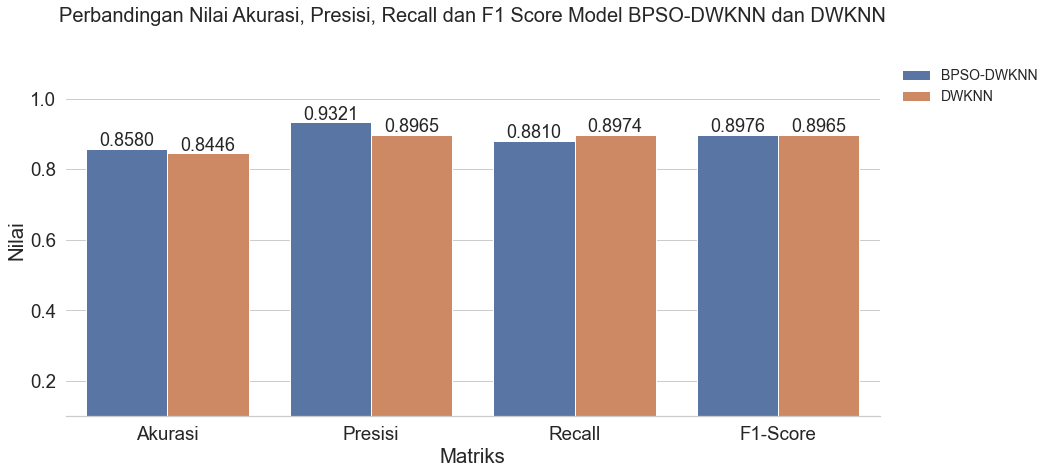

In [309]:
plt.figure(figsize=(15, 7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.7)
sns.set_style('whitegrid')
p = sns.barplot(x='Matriks', y='Nilai', hue='Model', data=max_all_df)
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14, frameon=False)
p.set_title('Perbandingan Nilai Akurasi, Presisi, Recall dan F1 Score Model BPSO-DWKNN dan DWKNN', fontsize=20, y=1.1)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/ConfusionMatrix BPSO-DW Vs DW.png')

## DataFrame to Excel

In [310]:
result_df = pd.DataFrame({'Model': ['BPSO-DWKNN', 'DWKNN'],
                      'Fold': [bpdw_df.Fold[np.argmax(bpdw_df.AkurasiTest)], dw_df.Fold[np.argmax(dw_df.AkurasiTest)]],
                      'Nilai K': [bpdw_df.Nilai_K[np.argmax(bpdw_df.AkurasiTest)], dw_df.Nilai_K[np.argmax(dw_df.AkurasiTest)]],
                      'Akurasi Train': [np.max(bpdw_df.AkurasiTrain.values), np.max(dw_df.AkurasiTrain.values)],
                      'Akurasi Test': [np.max(bpdw_df.AkurasiTest.values), np.max(dw_df.AkurasiTest.values)],
                      'Presisi': [bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.Presisi[np.argmax(dw_df.AkurasiTest.values)]],
                      'Recall': [bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.Recall[np.argmax(dw_df.AkurasiTest.values)]],
                      'F1-Score': [bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.F1_Score[np.argmax(dw_df.AkurasiTest.values)]],
                      'Jumlah Fitur': [np.count_nonzero(pop_pos[np.argmax(pop_acc)]), X.shape[1]],
                      })

C:\Anaconda\envs\jcopml\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [311]:
result_df

Model  Fold  Nilai K  Akurasi Train  Akurasi Test  Presisi  Recall  \
0  BPSO-DWKNN     9        1            1.0        0.8580   0.9321  0.8810   
1       DWKNN     3        1            1.0        0.8446   0.8965  0.8974   

   F1-Score  Jumlah Fitur  
0    0.8976          3771  
1    0.8965          7129

In [329]:
fold_fs_df.name = "Percobaan Fold Pada Seleksi Fitur"
w0_df.name = "W = 0.9"
w1_df.name = "W = 0.1"
pop_df.name = "Percobaan Populasi"
result_df.name = "Hasil Akurasi"
bpdw_df.name = "Akurasi Terbaik BPSO-DWKNN tiap Fold"
dw_df.name = "Akurasi Terbaik DWKNN tiap Fold"

acc_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

acc_d_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_d_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_d_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_d_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

writer = pd.ExcelWriter('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL.xlsx',engine='xlsxwriter')
workbook=writer.book

# Formating
merge_format = workbook.add_format({
    'bold': 1,
    'border': None,
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#fc8f30',
    'font_color': 'white'})

cell_format = workbook.add_format({
    'bg_color': '#ffdea1'})

border_fmt = workbook.add_format({
    'bottom':3, 
    'top':3, 
    'left':3, 
    'right':3})


# Excel Fold
worksheet=workbook.add_worksheet('Fold')
writer.sheets['Fold'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(fold_fs_df)+1, len(fold_fs_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', fold_fs_df.name, merge_format)
# to_xlsx
fold_fs_df.to_excel(writer,sheet_name='Fold',startrow=1 , startcol=0, index=None)

#Excel Parameter PSO
worksheet=workbook.add_worksheet('BPSOPar')
writer.sheets['BPSOPar'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(w0_df)+1, len(w0_df.columns)), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(2, 0, 6, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:F1', w0_df.name, merge_format)
# to_xlsx
w0_df.to_excel(writer,sheet_name='BPSOPar',startrow=1 , startcol=0)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 15, 5), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 10, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(11, 0, 15, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A10:F10', w1_df.name, merge_format)
# to_xlsx
w1_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + 5, startcol=0)
# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 23, 6), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 19, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A19:G19', pop_df.name, merge_format)
# to_xlsx
pop_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + w1_df.shape[0] + 9, startcol=0, index=None)

# Excel Tabel Akurasi Terbaik BPSO-DW Tiap Fold
worksheet=workbook.add_worksheet('BPSO-DWKNN')
writer.sheets['BPSO-DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(bpdw_df)+1, len(bpdw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 7), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:H1', bpdw_df.name, merge_format)
# to_xlsx
bpdw_df.to_excel(writer,sheet_name='BPSO-DWKNN',startrow=1 , startcol=0, index=None)

# Excel Tabel Akurasi Terbaik DW Tiap Fold
worksheet=workbook.add_worksheet('DWKNN')
writer.sheets['DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(dw_df)+1, len(dw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', dw_df.name, merge_format)
# to_xlsx
dw_df.to_excel(writer,sheet_name='DWKNN',startrow=1 , startcol=0, index=None)

#Excel Hasil Akhir
worksheet=workbook.add_worksheet('Hasil Akurasi')
writer.sheets['Hasil Akurasi'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(result_df)+1, len(result_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 8), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:I1', result_df.name, merge_format)
# to xlsx
result_df.to_excel(writer,sheet_name='Hasil Akurasi',startrow=1 , startcol=0, index=None)

#Excel Acc, prc, rcl, f1 BPSO DW perFold
worksheet=workbook.add_worksheet('BPSO-DW Acc, Prc, Rcl, F1')
writer.sheets['BPSO-DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_bpdw_k_df)+1, len(acc_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_bpdw_k_df.name, merge_format)
# to xlsx
acc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_bpdw_k_df.name, merge_format)
# to_xlsx
prc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_bpdw_k_df.name, merge_format)
# to_xlsx
f1_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 5 + rcl_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

#Excel Acc, prc, rcl, f1 DW perFold
worksheet=workbook.add_worksheet('DW Acc, Prc, Rcl, F1')
writer.sheets['DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_d_bpdw_k_df)+1, len(acc_d_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_d_bpdw_k_df.name, merge_format)
# to xlsx
acc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_d_bpdw_k_df.name, merge_format)
# to_xlsx
prc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_d_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_d_bpdw_k_df.name, merge_format)
# to_xlsx
f1_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 5 + rcl_d_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

writer.save()

## Plot Per Fold

### BPSO-DWKNN

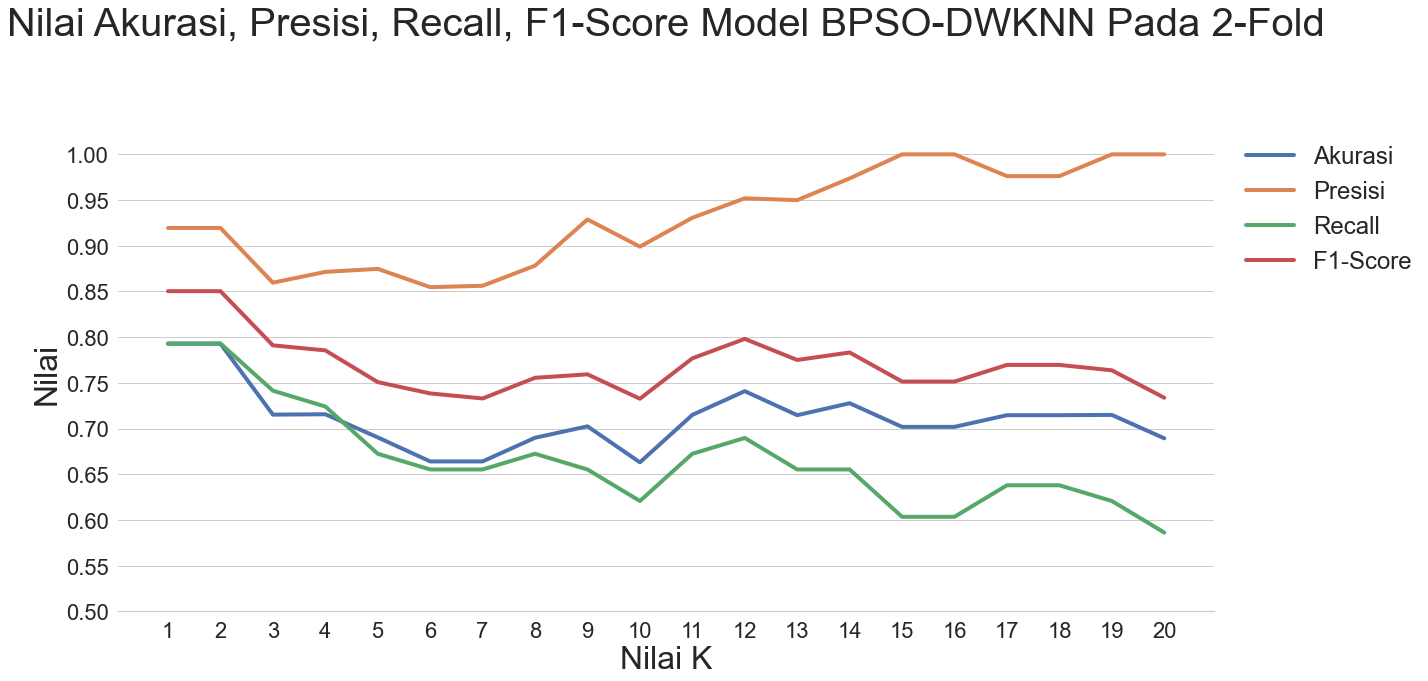

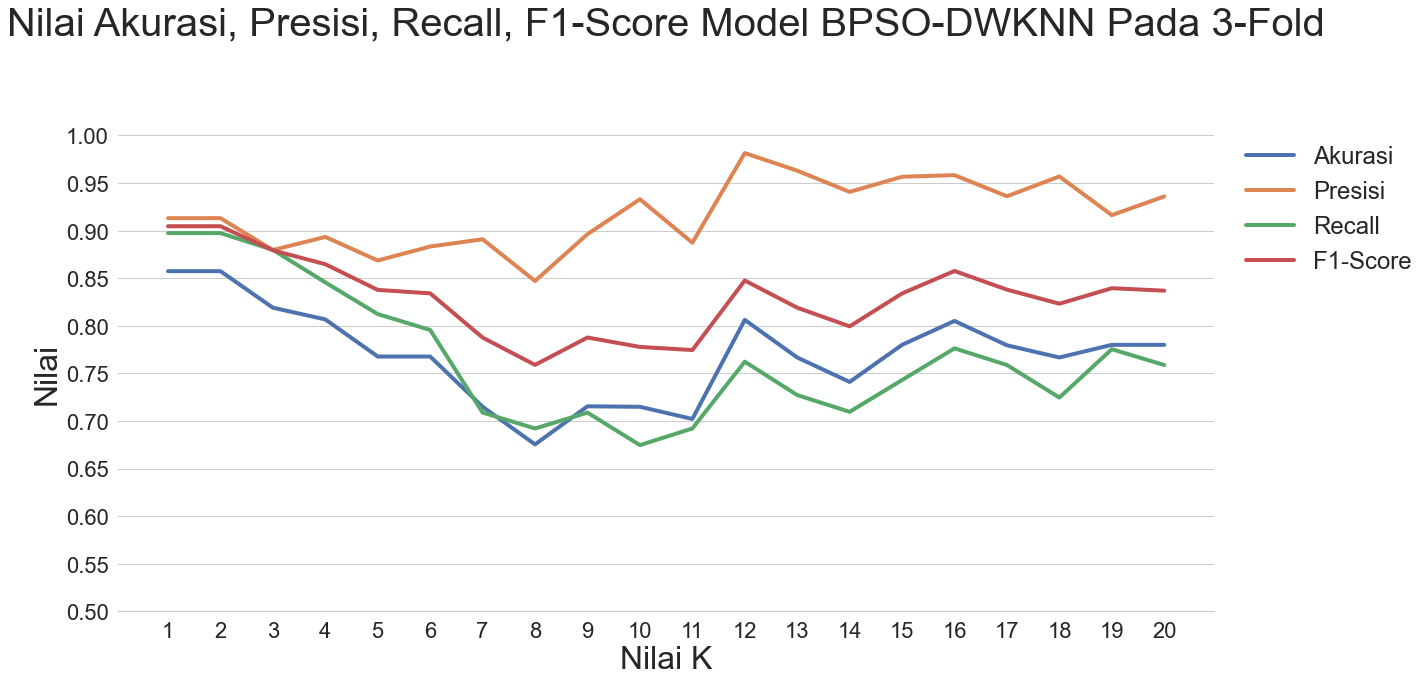

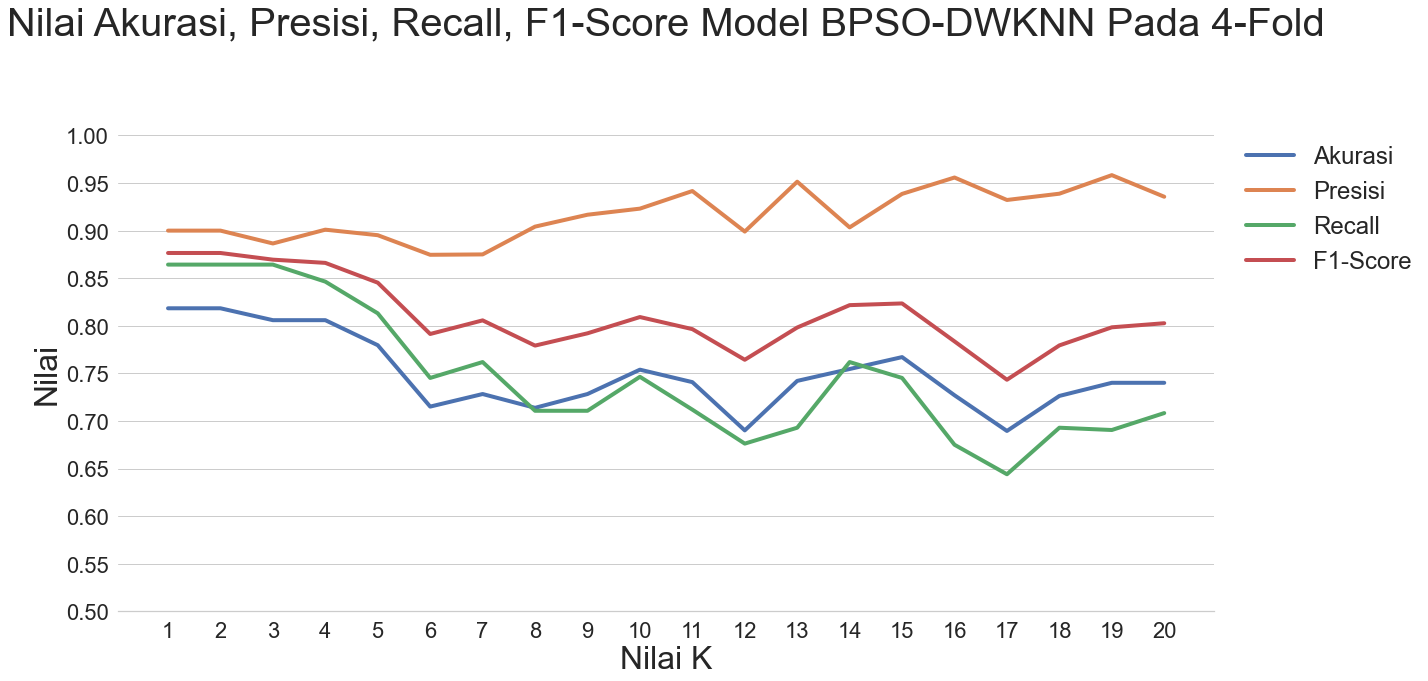

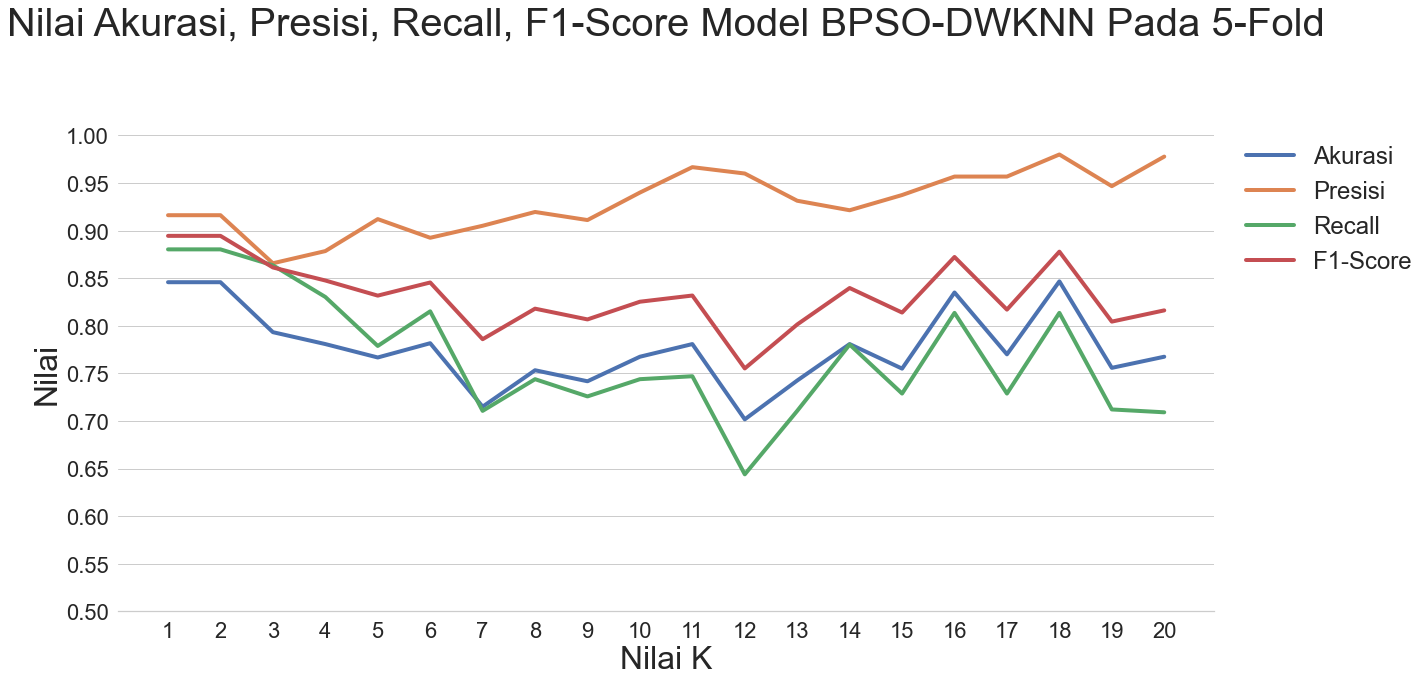

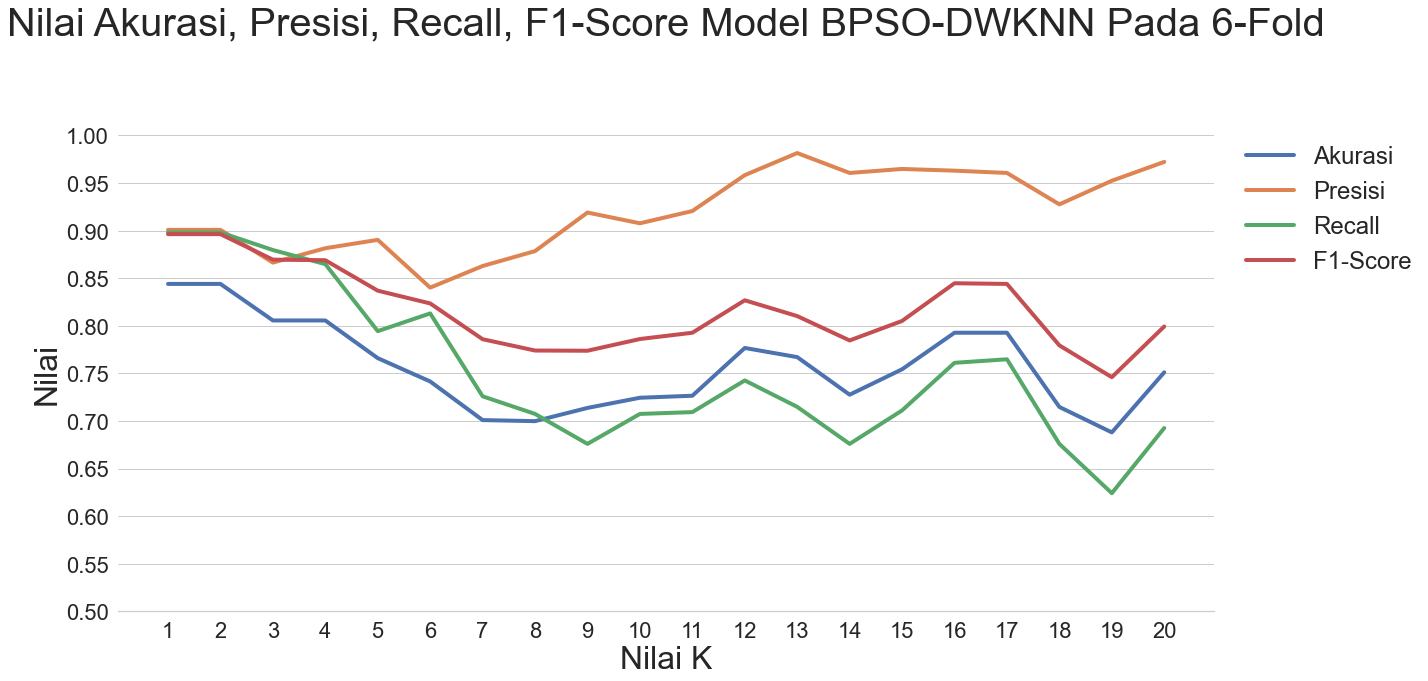

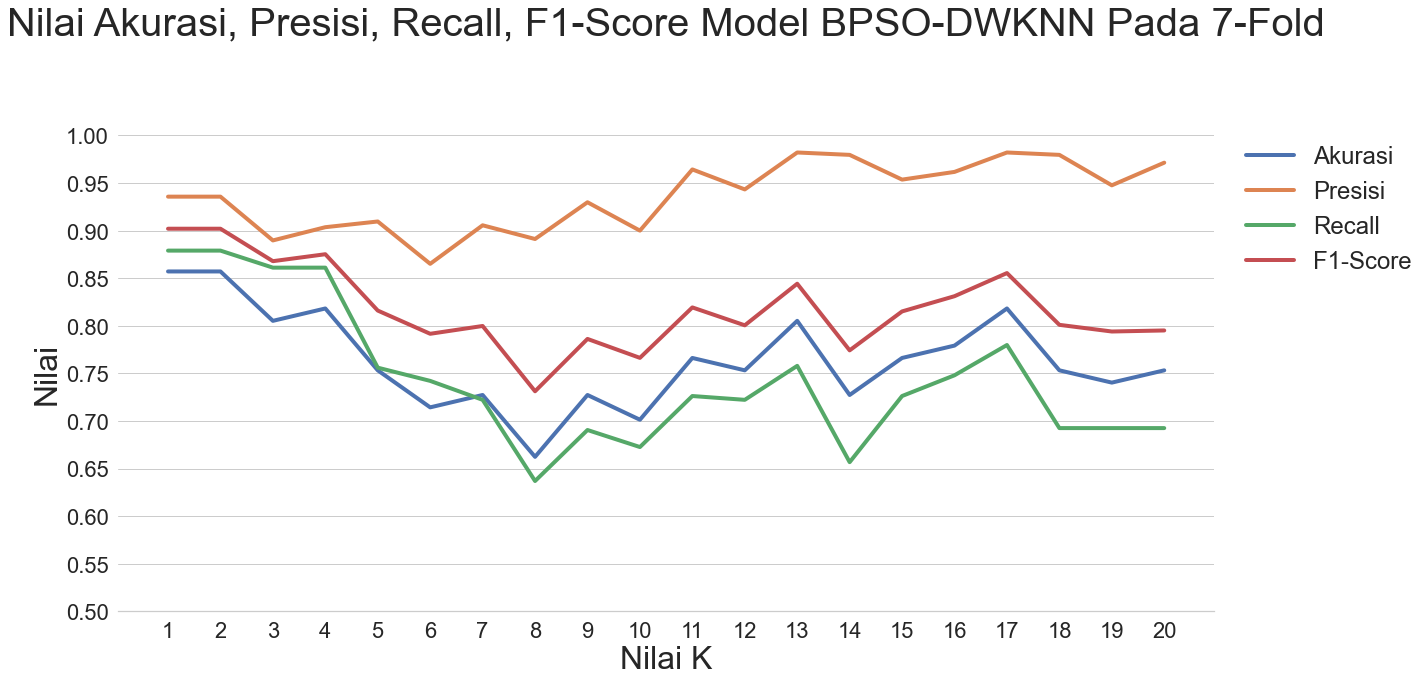

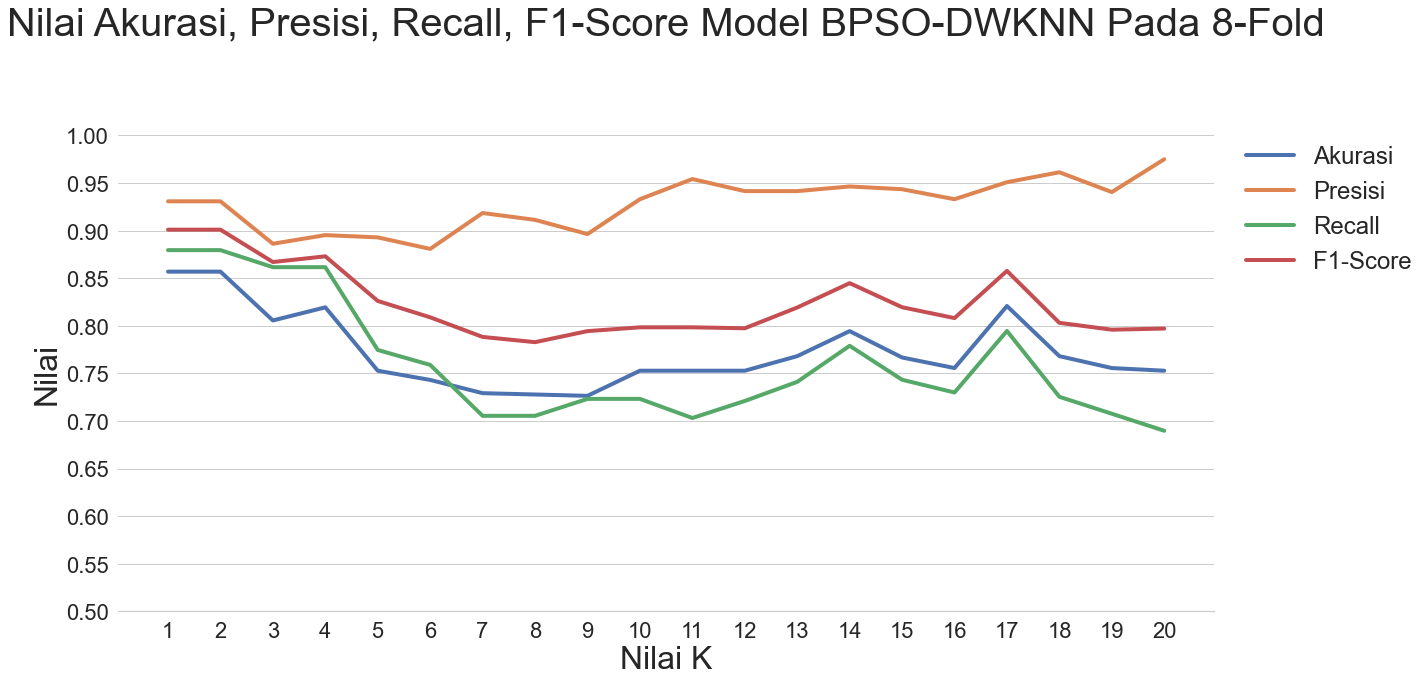

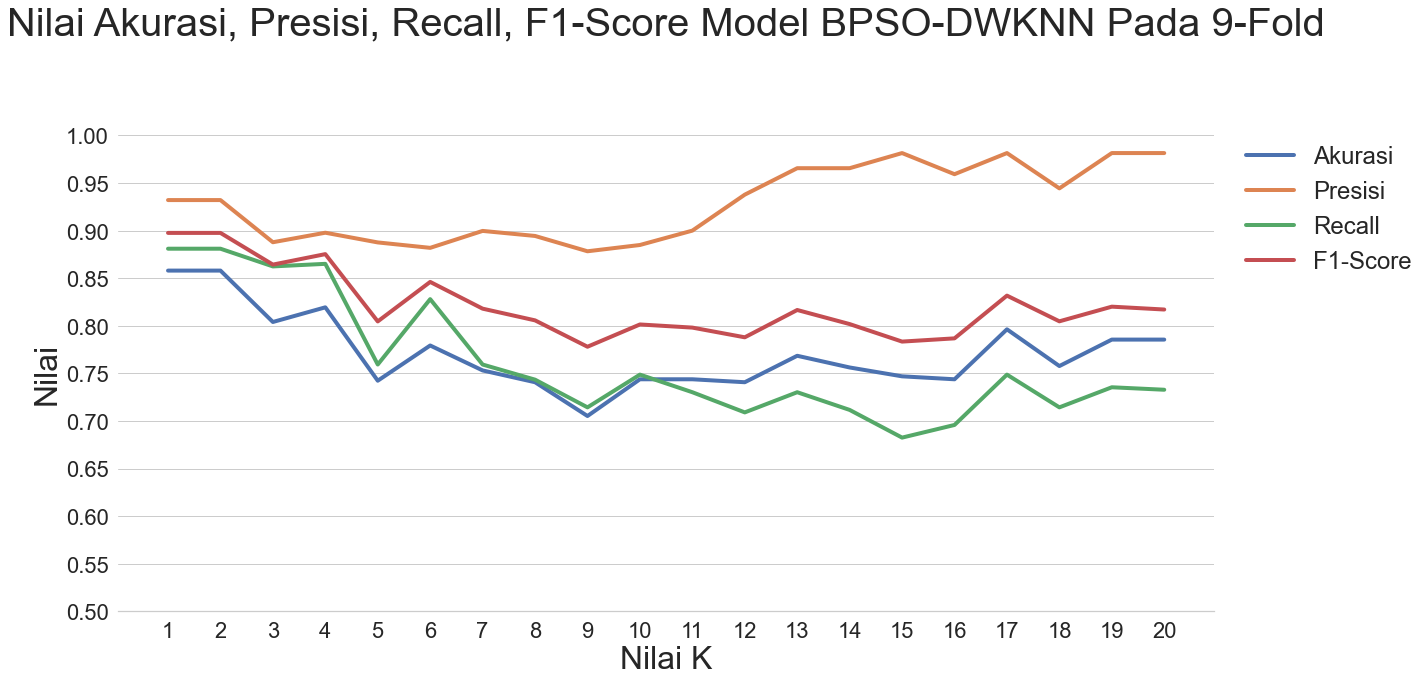

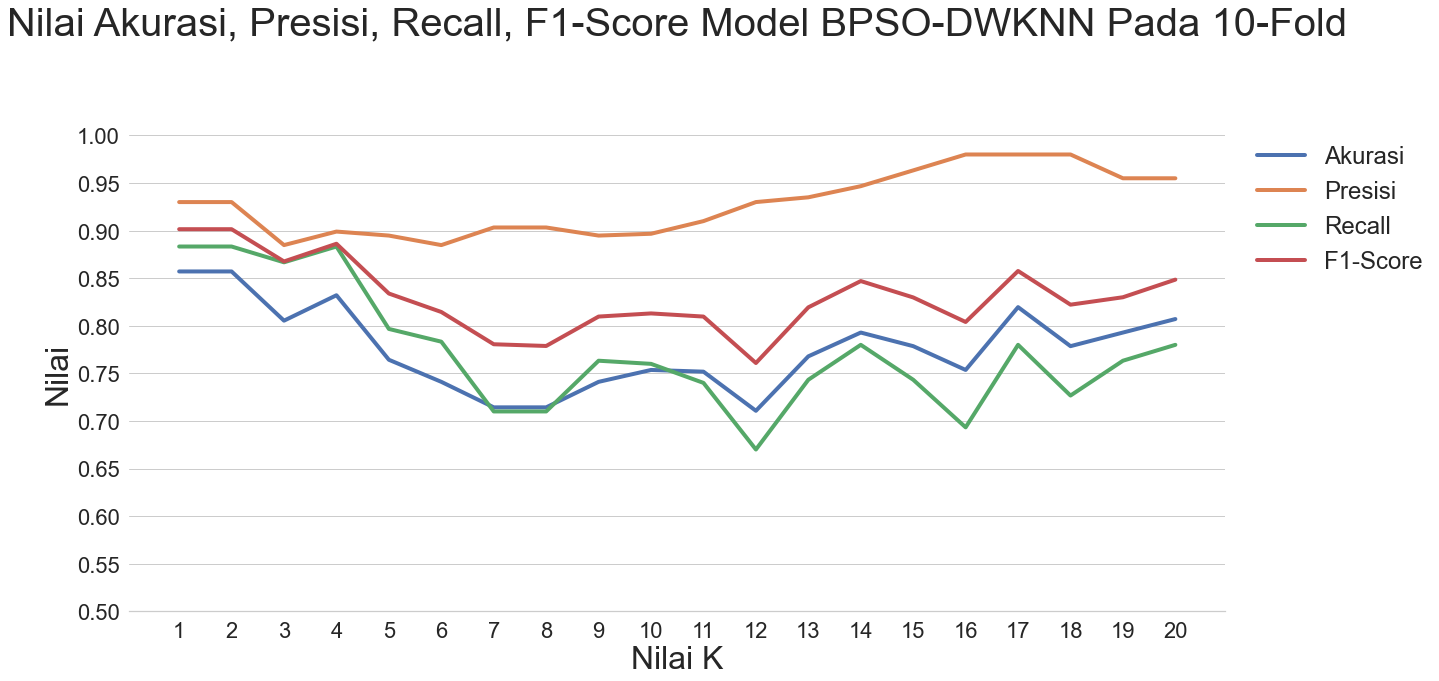

In [313]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model BPSO-DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/BPSO-DW Per Fold/BPSO-DW {}-Fold.png'.format(i+2))
    


### DWKNN

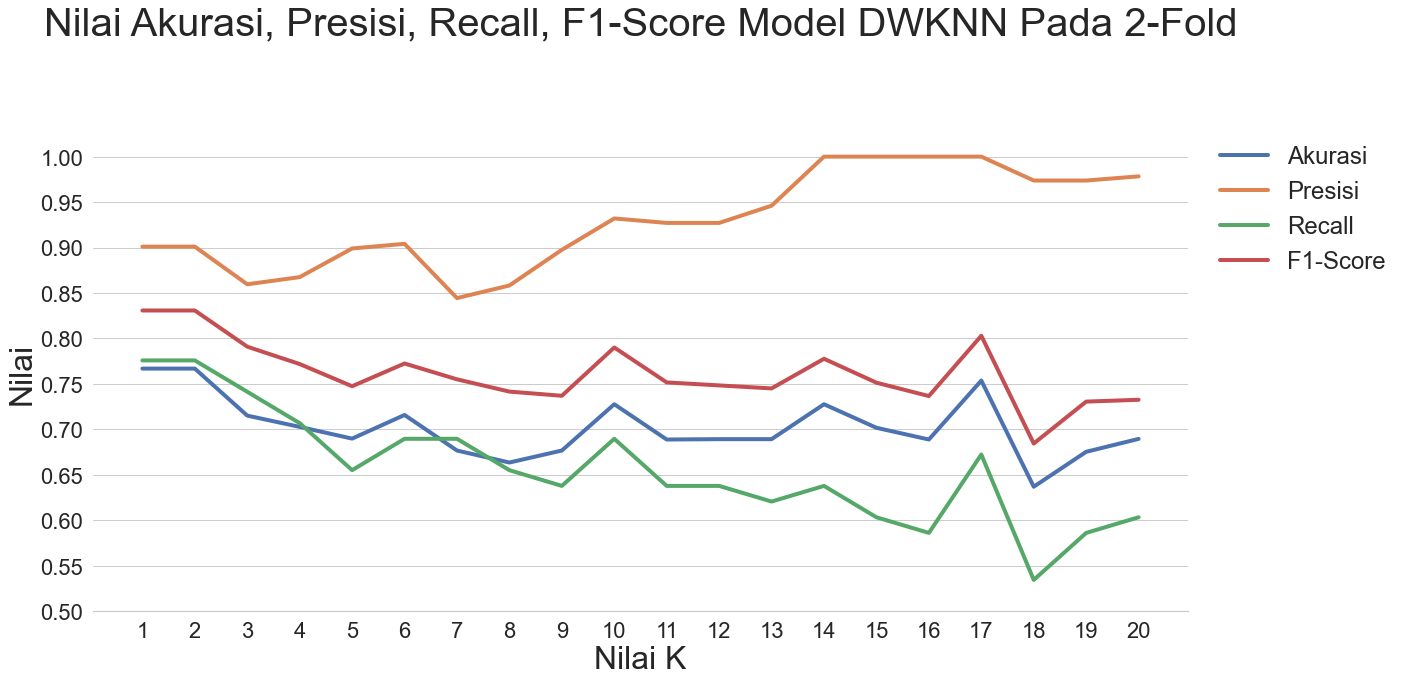

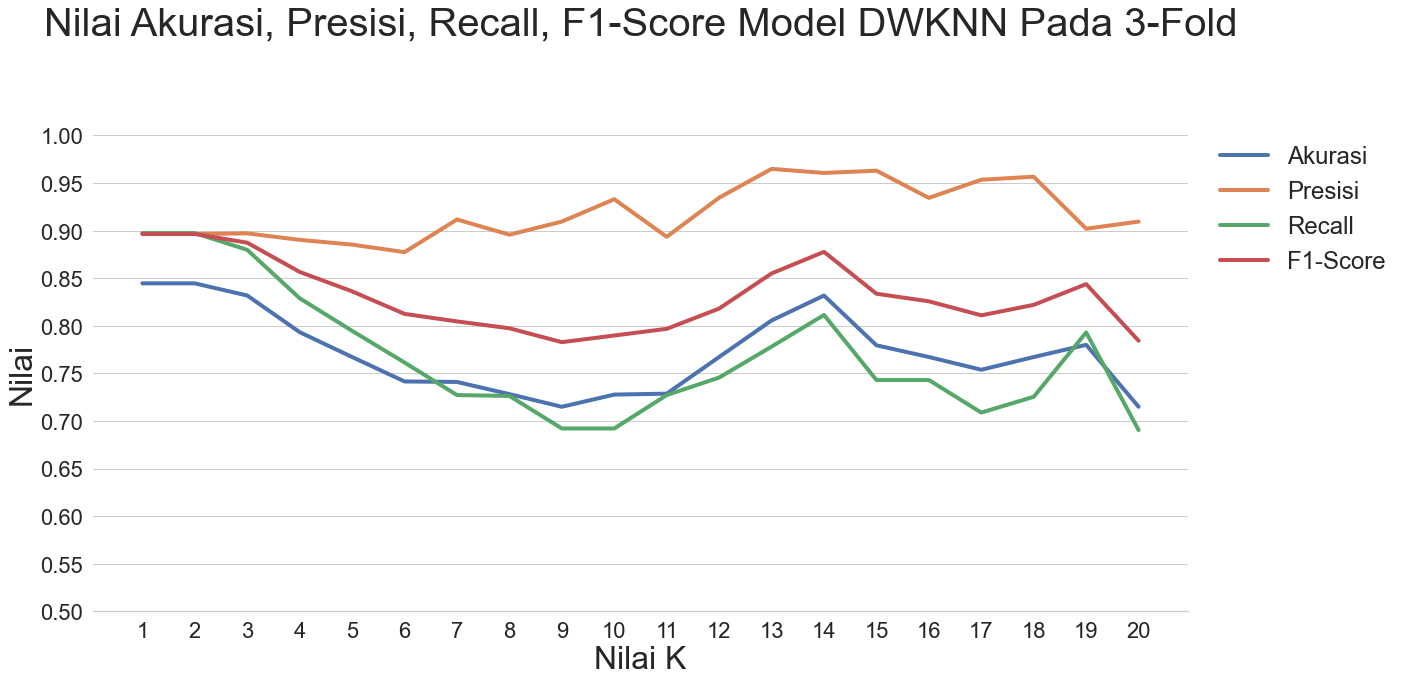

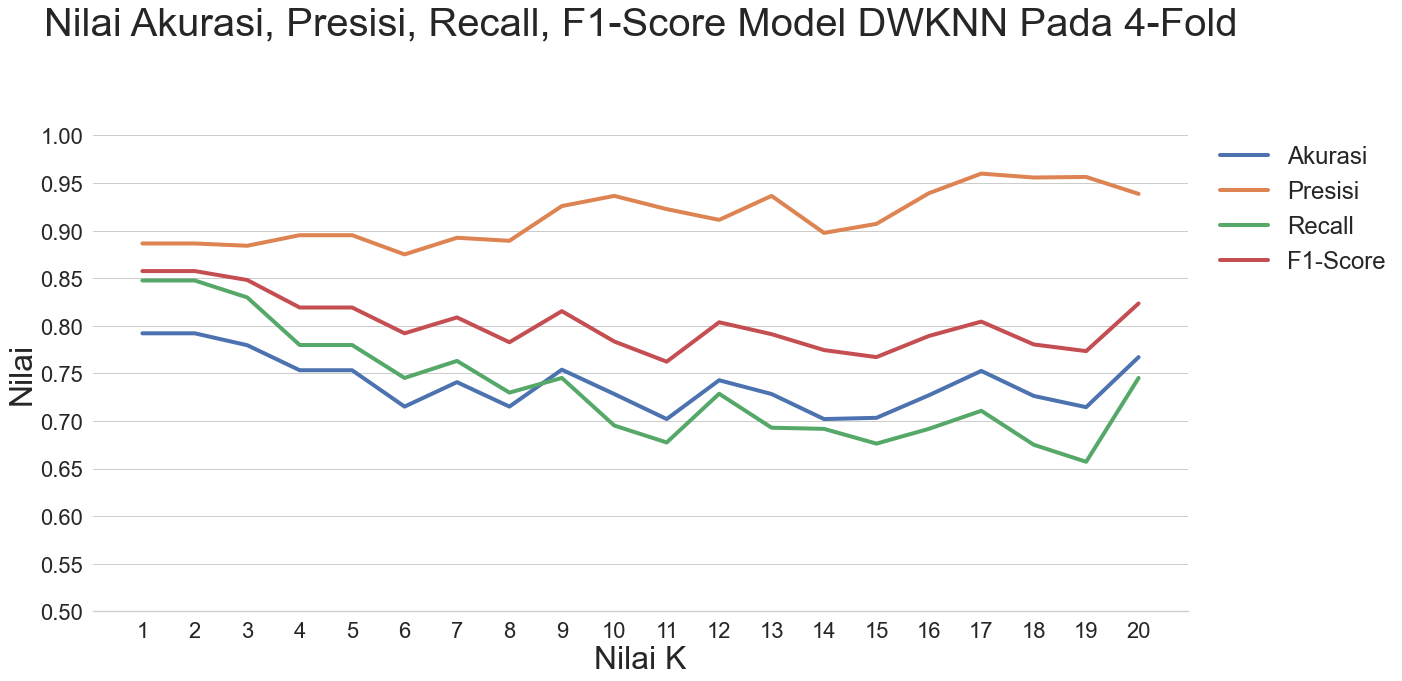

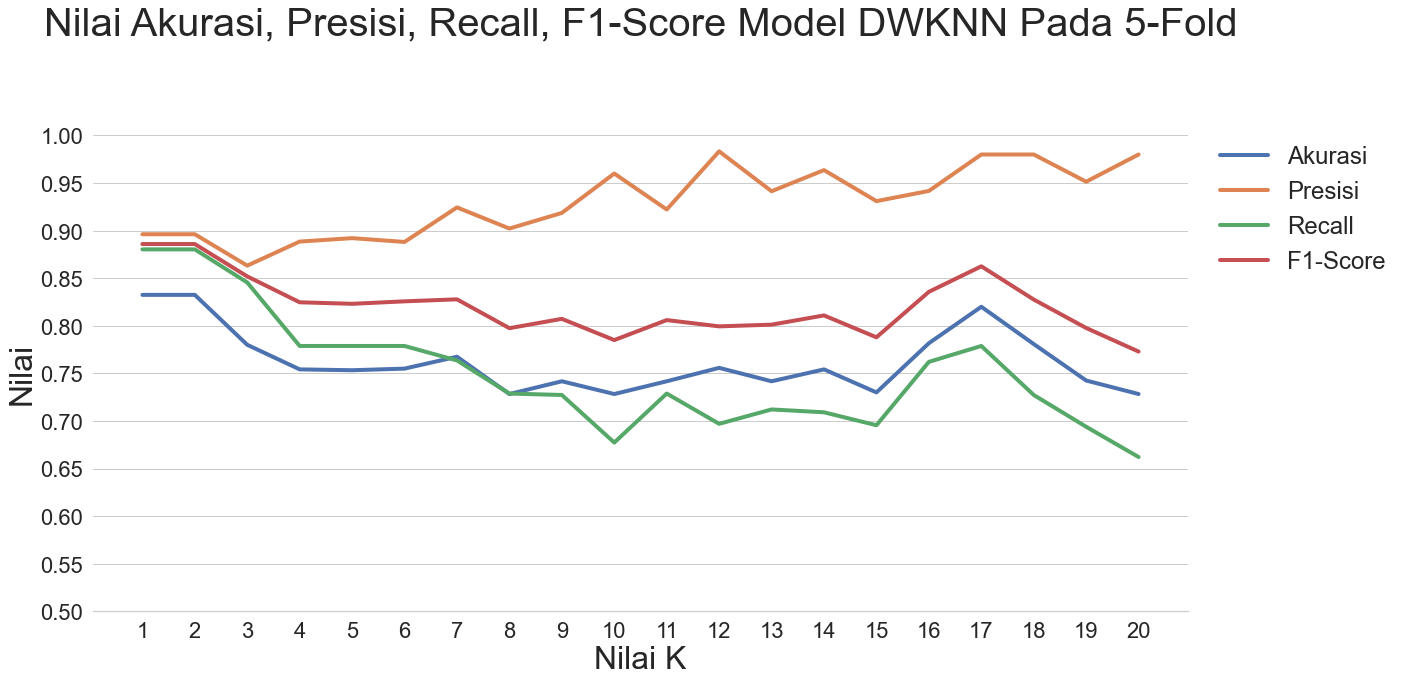

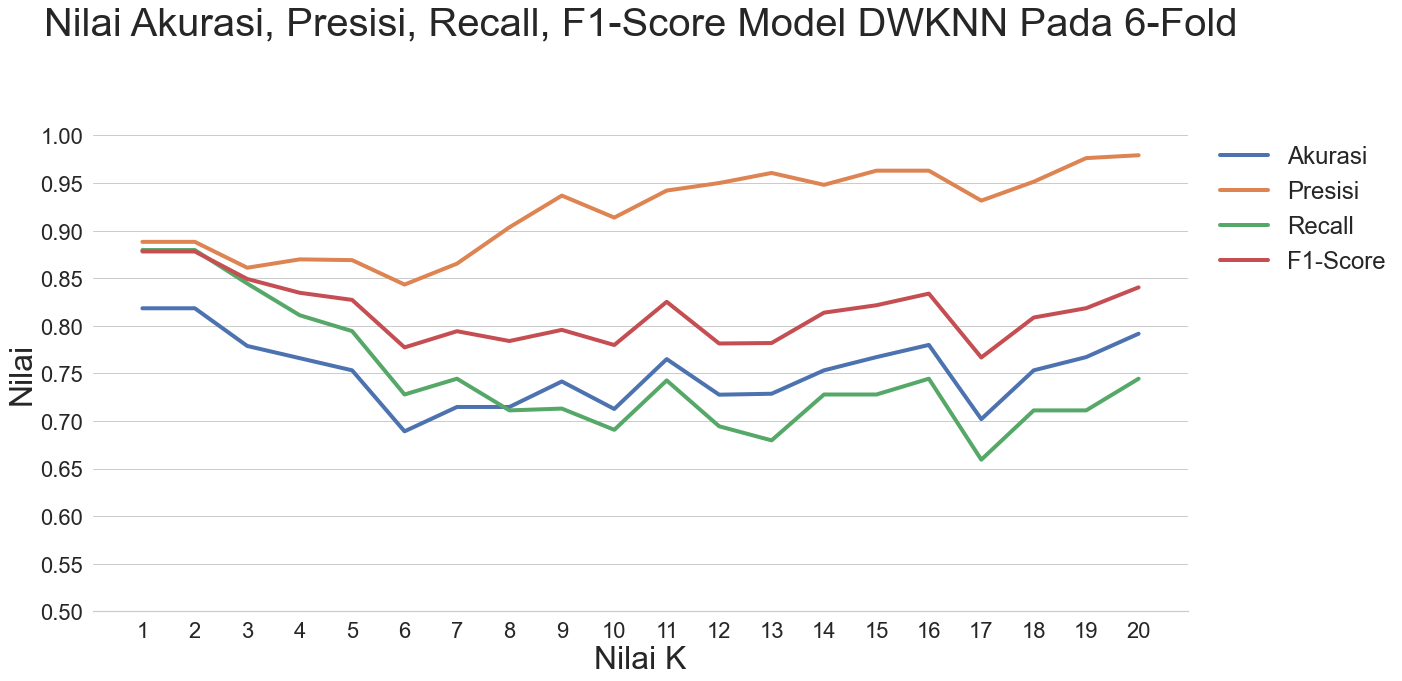

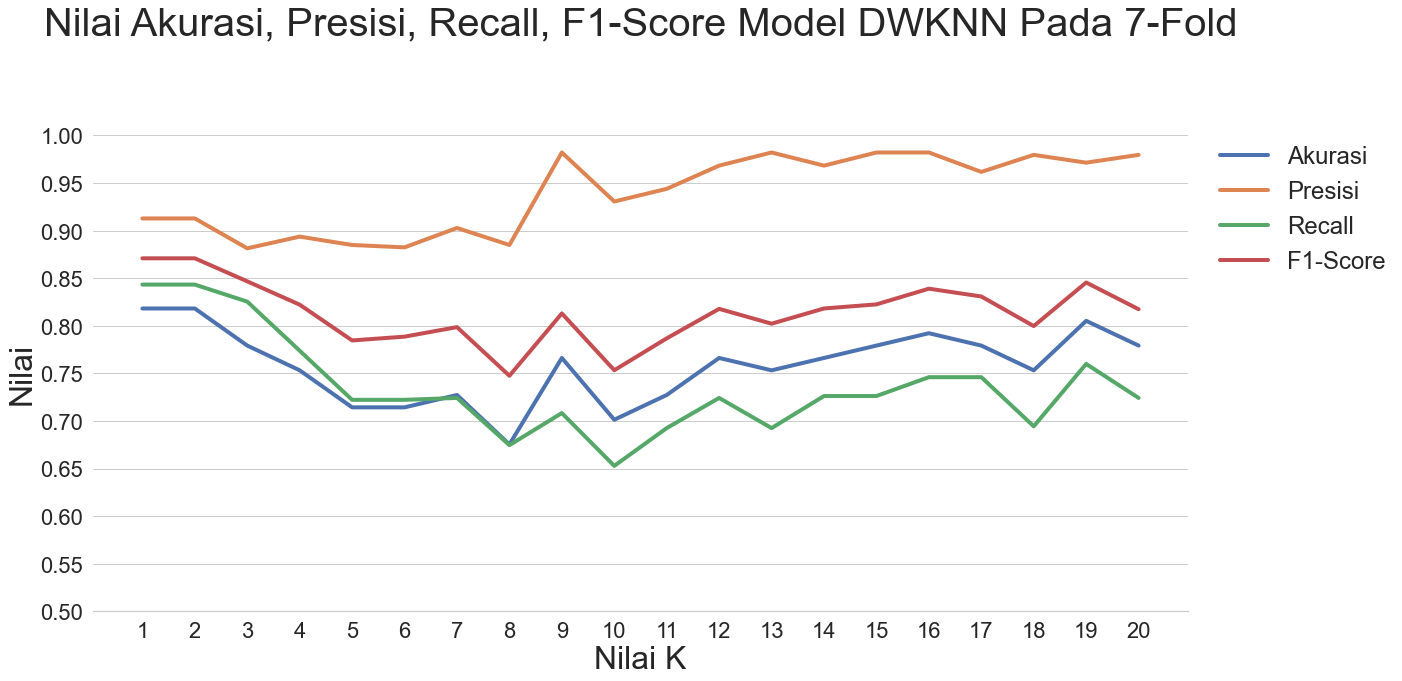

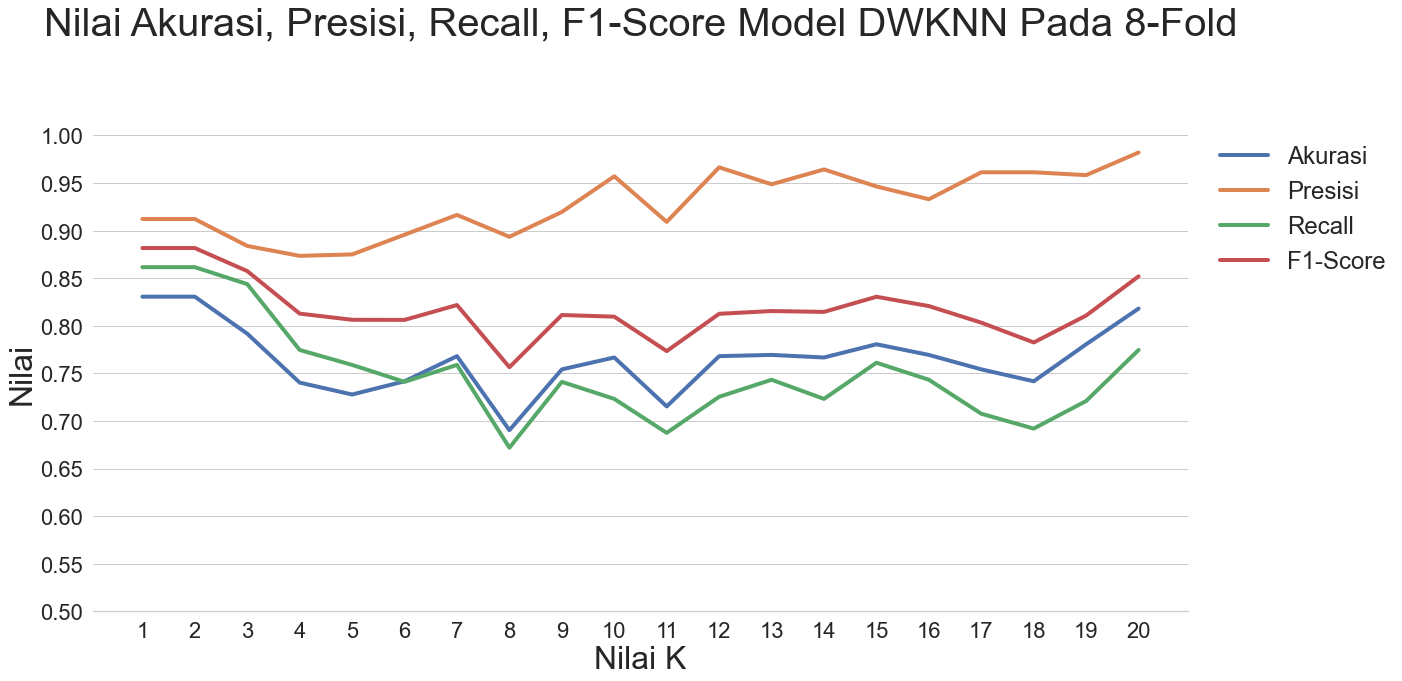

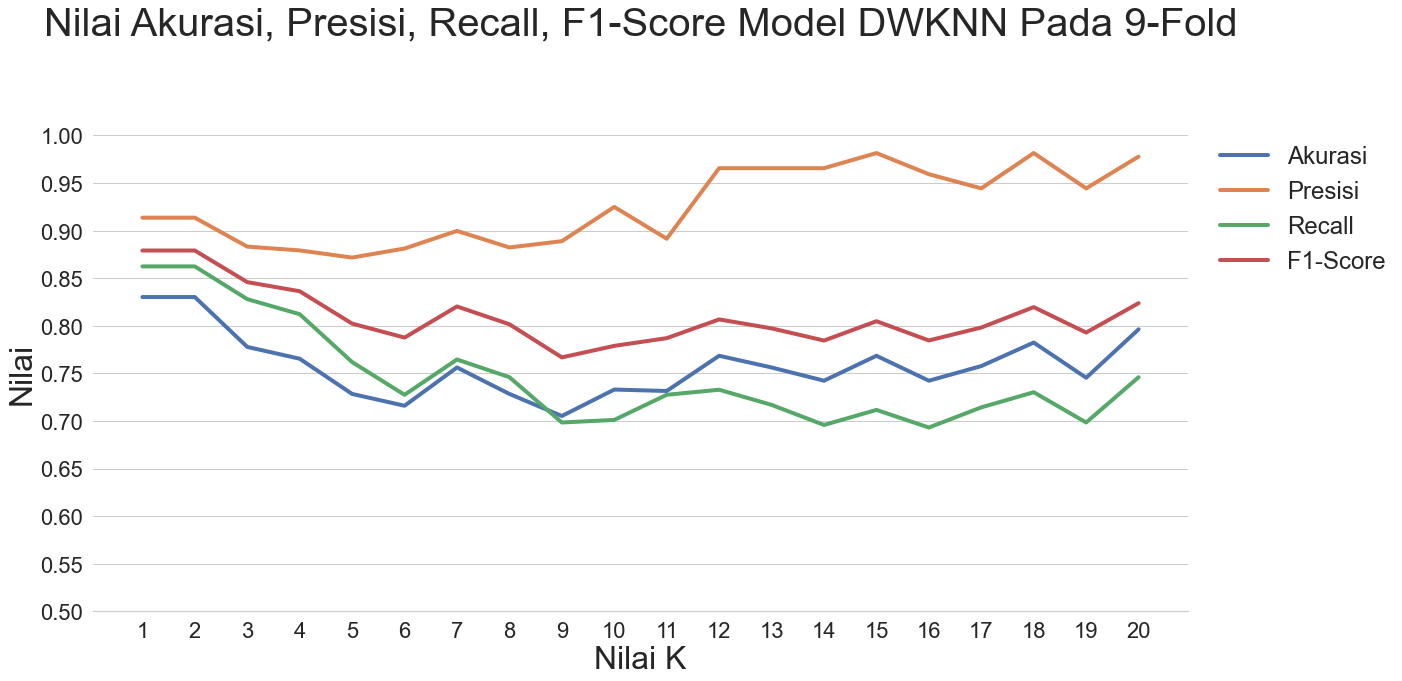

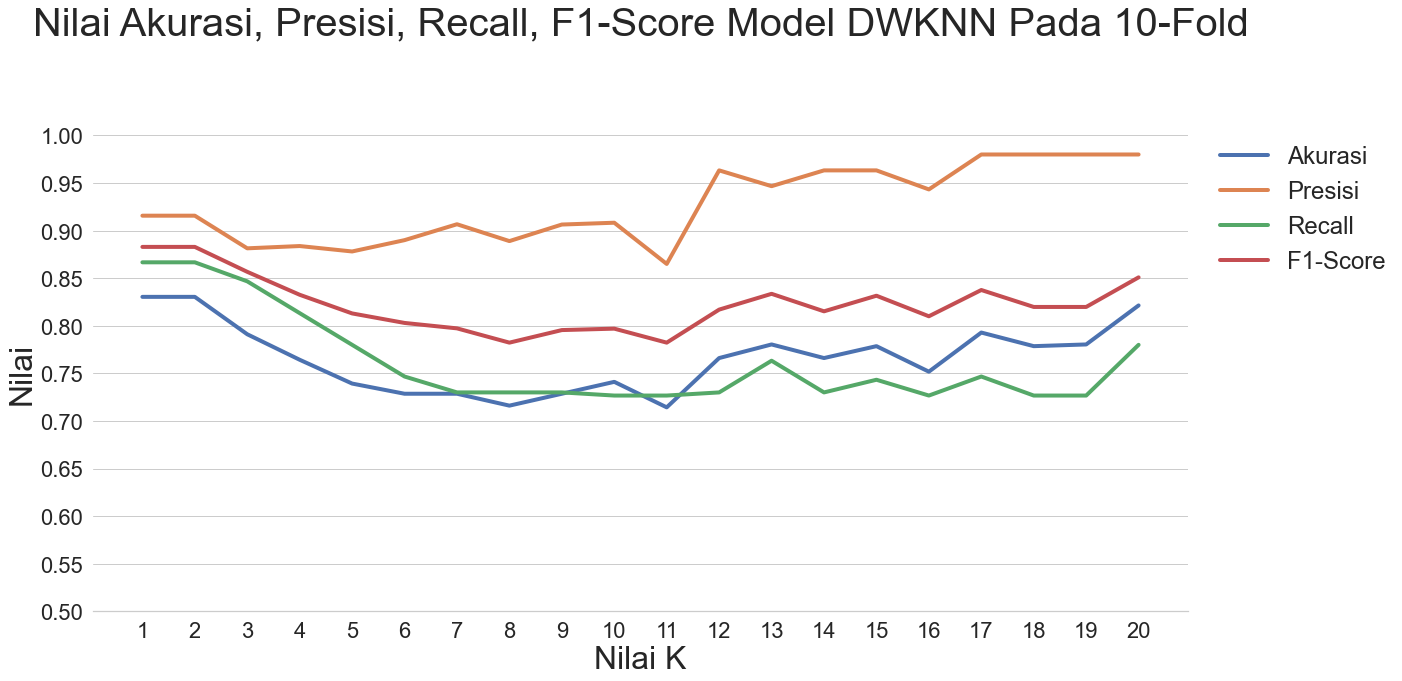

In [314]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/DLBCL/DW Per Fold/DW {}-Fold.png'.format(i+2))